#Medición Prueba de Control
Archivo para medir las diferencias de accesos y lecturas en el grupo experimental frente al de control **(OJO, hay que añadir tb la parte de producción y tendencia).**

Diariamente se descargan los datos de la auditoria de los usuarios desde el lunes sábado 13 de Abril de 2024 a las 00:00 horas hasta el momento actual.

In [7]:
pip install unidecode

In [8]:
import os
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt

Defino el grupo experimental como Gr1 y el de control como Gr2.

Hay que tener en cuenta que agentes_inicio son todos los agentes que había el viernes 12 de Abril, se hará un cruce con los agentes del grupo experimental para crear el Gr1.

##Archivos necesarios
Auditoria (descargar todos los días), 1.18 para ver las bajas (descargar todos los días), estructura comercial, grupo control, estandar grupo experimental, formacion grupo experimental, exp_ctrl que es auditoria meses previos grupo experimental (descargar todos los días para meses (o semanas) previos), el 1.12.1 producción por meses (descargar de vez en cuando) y el 1.26 mensual para ver el tipo de producción que se ha realizado (descargar diariamente el mes actual).

Subir todos al colab para ser ejecutados.

In [107]:
accesos_usuarios_df = pd.read_excel('/content/2.13_Auditoria_usuarios.xlsx')
agentes_inicio = pd.read_excel('/content/1.18_Estructura_Comercial.xlsx')
Gr2 = pd.read_excel('/content/1.18_Grupo_de_control.xlsx')
est_gr_exp = pd.read_excel('/content/estandar_gr_exp.xlsx')
for_gr_exp = pd.read_excel('/content/formacion_gr_exp.xlsx')
bajas = pd.read_excel('/content/1.18_Bajas.xlsx')
prod_fis_corr = pd.read_excel('/content/1.12.1_Produccion_Meses.xlsx')
prod_enero = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Enero.xlsx')
prod_febrero = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Febrero.xlsx')
prod_marzo = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Marzo.xlsx')
prod_abril = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Abril.xlsx')
prod_mayo = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Mayo.xlsx')
# prod_junio = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Junio.xlsx')

# Prueba grupo experimental como grupo de control_2
aud_gr1_2 = pd.read_excel('/content/Exp_Ctrl.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Definición de funciones de limpieza y normalización de los dataframes.

In [108]:
def cols_to_keep(df):
  cols = ['SUCURSAL', 'OFICINA', 'PV', 'CODIGO', 'COD. CALLIDUS/SOLNET', 'LDAP', 'NIF', 'NOMBRE', 'TIPOLOGIA', 'F.ALTA']
  df = df[cols]
  return df

def clean_df(df):
    # Convertir todas las columnas de tipo object a mayúsculas, excepto las especificadas
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(lambda x: unidecode(x.upper()) if isinstance(x, str) else x)

    # Ahora, aplicamos unidecode a los nombres de las columnas
    df.columns = [unidecode(col.upper()) for col in df.columns]
    return df

def date_delete(df):
    df['DIA'] = df['FECHA ESPANOLA'].dt.day
    df['MES'] = df['FECHA ESPANOLA'].dt.month

    # Elimino la columna fecha del servidor, ya que nos vamos a quedar solo con la fecha española
    del_columns = ['FECHA SERVIDOR']
    df.drop(columns=del_columns, inplace=True)
    # Elimino la columna unnamed si la hay
    if 'UNNAMED: 0' in df.columns:
      df.drop(columns='UNNAMED: 0', inplace=True)
    return df

def clean_production(df):
    columns = ['POSITIONNAME', 'FEC. ALTA', 'POL. FIS. 2024-01', 'POL. FIS. 2024-02', 'POL. FIS. 2024-03', 'POL. FIS. 2024-04', 'POL. FIS. 2024-05', 'POL. CORR. 2024-01', 'POL. CORR. 2024-02', 'POL. CORR. 2024-03', 'POL. CORR. 2024-04', 'POL. CORR. 2024-05']
    df = df[columns]
    df['PRIMER TRIM POL FIS'] = df['POL. FIS. 2024-01'] + df['POL. FIS. 2024-02'] + df['POL. FIS. 2024-03']
    df['SEGUNDO TRIM POL FIS'] = df['POL. FIS. 2024-04'] + df['POL. FIS. 2024-05']
    # SUMAR EL RESTO DE MESES CUANDO ESTÉN + df['POL. FIS. 2024-06']

    df['POL. CORR. 2024-01'] = pd.to_numeric(df['POL. CORR. 2024-01'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-02'] = pd.to_numeric(df['POL. CORR. 2024-02'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-03'] = pd.to_numeric(df['POL. CORR. 2024-03'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-04'] = pd.to_numeric(df['POL. CORR. 2024-04'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-05'] = pd.to_numeric(df['POL. CORR. 2024-05'].astype(str).str.replace(',', '.'), errors='coerce')
    # df['POL. CORR. 2024-06'] = pd.to_numeric(df['POL. CORR. 2024-06'].astype(str).str.replace(',', '.'), errors='coerce')

    df['PRIMER TRIM POL CORR'] = df['POL. CORR. 2024-01'] + df['POL. CORR. 2024-02'] + df['POL. CORR. 2024-03']
    df['SEGUNDO TRIM POL CORR'] = df['POL. CORR. 2024-04'] + df['POL. CORR. 2024-05']
    # SUMAR EL RESTO DE MESES CUANDO ESTÉN + df['POL. CORR. 2024-06']
    return df

def cols_prod_month(df):
  cols = ['SUCURSAL', 'OFICINA', 'COD. AGENTE', 'NIF', 'POL. FIS. HOGAR', 'POL. FIS. RRTT', 'POL. FIS. RRPP', 'ASEG.', 'POL. CORREG.', 'POL. FISIC.', 'RAPPEL', 'IMP. MENSUAL XL', 'IMP. MENSUAL XXL', 'RAPPEL_TOTAL', 'COBRA_RAPPEL', 'COBRA_RAPPELXXL']
  # Sumar todos los rappeles en uno para poder visualizarlo luego
  df['RAPPEL_TOTAL'] = df['RAPPEL'] + df['IMP. MENSUAL XL'] + df['IMP. MENSUAL XXL']
  # Crear la columna 'COBRA_ALGO' en función de si 'RAPPEL' es distinto de 0
  df['COBRA_RAPPEL'] = np.where(df['RAPPEL'] != 0, 1, 0)
  df['COBRA_RAPPELXXL'] = np.where(df['IMP. MENSUAL XXL'] != 0, 1, 0)

  df = df[cols]
  return df

In [109]:
# Limpieza y normalización de los dataframes
accesos_usuarios_df = clean_df(accesos_usuarios_df)
accesos_usuarios_df = date_delete(accesos_usuarios_df)

aud_gr1_2 = clean_df(aud_gr1_2)
aud_gr1_2 = date_delete(aud_gr1_2)

agentes_inicio = cols_to_keep(agentes_inicio)
agentes_inicio = clean_df(agentes_inicio)

Gr2 = cols_to_keep(Gr2)
Gr2 = clean_df(Gr2)

for_gr_exp = clean_df(for_gr_exp)
est_gr_exp = clean_df(est_gr_exp)

bajas = clean_df(bajas)

prod_fis_corr = clean_df(prod_fis_corr)
prod_fis_corr = clean_production(prod_fis_corr)

prod_enero = clean_df(prod_enero)
prod_enero = cols_prod_month(prod_enero)
prod_febrero = clean_df(prod_febrero)
prod_febrero = cols_prod_month(prod_febrero)
prod_marzo = clean_df(prod_marzo)
prod_marzo = cols_prod_month(prod_marzo)
prod_abril = clean_df(prod_abril)
prod_abril = cols_prod_month(prod_abril)
prod_mayo = clean_df(prod_mayo)
prod_mayo = cols_prod_month(prod_mayo)
# prod_junio = clean_df(prod_junio)
# prod_junio = cols_prod_month(prod_junio)

<ipython-input-108-3ef832ed64d0>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-108-3ef832ed64d0>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-108-3ef832ed64d0>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-108-

In [110]:
# Elimino a IRENE DELGADO JIMENEZ el outlier del Grupo de ctrl
Gr2 = Gr2[Gr2['NOMBRE'] != 'IRENE DELGADO JIMENEZ']
Gr2 = Gr2[Gr2['NOMBRE'] != 'ALICIA GOBIERNO ALONSO']

In [111]:
gr_exp = pd.concat([for_gr_exp, est_gr_exp], ignore_index=True)

In [112]:
Gr1_2 = agentes_inicio[agentes_inicio['COD. CALLIDUS/SOLNET'].isin(gr_exp['NAME'])]

In [113]:
Gr1 = agentes_inicio[agentes_inicio['COD. CALLIDUS/SOLNET'].isin(gr_exp['NAME'])]

La columna 'LDAP' es el código que identifica al agente en los archivos Gr1 y Gr2, y 'USERID' en accesos_usuarios_df, los que hay que tener en cuenta al cruzar los dataframes.

Los mezclo para quedarme con todas las columnas y poder hablar de sucursales y otros conceptos.

In [114]:
accesos_gr_exp = pd.merge(accesos_usuarios_df, Gr1, how = 'inner', left_on = 'USERID', right_on = 'LDAP')
accesos_gr_ctrl = pd.merge(accesos_usuarios_df, Gr2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

accesos_gr_ctrl1_2 = pd.merge(aud_gr1_2, Gr1_2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

prueba = pd.merge(aud_gr1_2, Gr2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

##Distintas formas de medición


###Diferencia por Tipos de evento

Vemas cuáles son las diferencias entre los diferentes tipos de evento (LOGIN, LOGOUT, VIEW y READ) entre el grupo de control y el experimental.

#####Experimental VS Control

In [115]:
dif_eventos_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO'], as_index=False).count()
dif_eventos_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO'], as_index=False).count()

dif_eventos_ctrl1_2 = accesos_gr_ctrl1_2.groupby(by=['TIPO EVENTO'], as_index=False).count()

**OJO: ¿cómo puedo cambiar la leyenda?**

<ipython-input-116-efb508bc054c>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



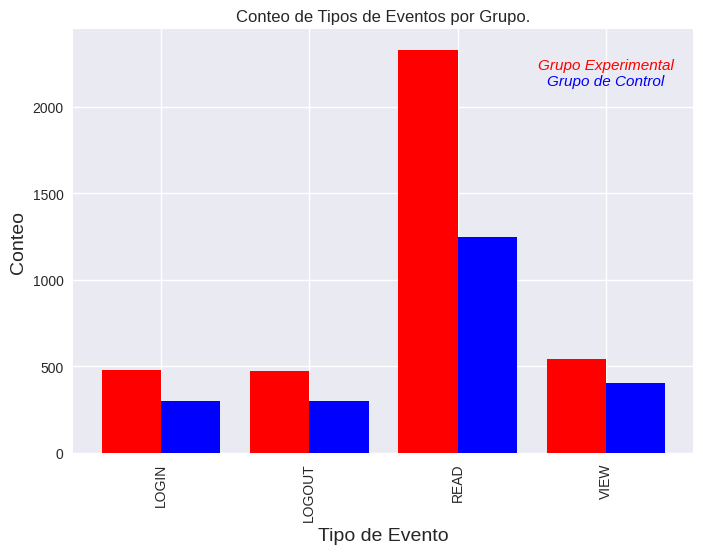

In [116]:
plt.style.use('seaborn')
ax = dif_eventos_exp['USERID'].plot(kind="bar", width=-0.4, rot=0, stacked=True, align='edge', color="red")
dif_eventos_ctrl['USERID'].plot(ax=ax, width=0.4, kind="bar",align='edge', color="blue")
ax.set_xticklabels(dif_eventos_exp['TIPO EVENTO'])
ax.set_ylabel('Conteo', fontsize = 14)
ax.set_xlabel('Tipo de Evento', fontsize = 14)
# ax.legend(title='DataFrame')
ax.set_title('Conteo de Tipos de Eventos por Grupo.')
ax.text(3, 2150, "Grupo de Control",
       fontsize = 11,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "blue",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
ax.text(3, 2240, "Grupo Experimental",
       fontsize = 11,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "red",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
plt.autoscale(enable=True, axis='x')
plt.show()

In [117]:
for i in range(len(dif_eventos_exp)):
  porcentaje = round((dif_eventos_ctrl['USERID'].iloc[i-1]*100)/dif_eventos_exp['USERID'].iloc[i-1],2)
  print('El evento', dif_eventos_exp['TIPO EVENTO'].iloc[i-1], 'del grupo de control supone un ', porcentaje, '% siendo el 100 % lo recogido en el grupo experimental.')
  print('Que se corresponde con', dif_eventos_ctrl['USERID'].iloc[i-1],'registros obtenidos del grupo de control y', dif_eventos_exp['USERID'].iloc[i-1], 'del grupo experimental.\n')

El evento VIEW del grupo de control supone un  74.45 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 405 registros obtenidos del grupo de control y 544 del grupo experimental.

El evento LOGIN del grupo de control supone un  62.97 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 301 registros obtenidos del grupo de control y 478 del grupo experimental.

El evento LOGOUT del grupo de control supone un  62.95 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 299 registros obtenidos del grupo de control y 475 del grupo experimental.

El evento READ del grupo de control supone un  53.5 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 1247 registros obtenidos del grupo de control y 2331 del grupo experimental.



#####Grupo Experimental (1º Trim VS 2º Trim)

<ipython-input-118-4c5843b3aedf>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



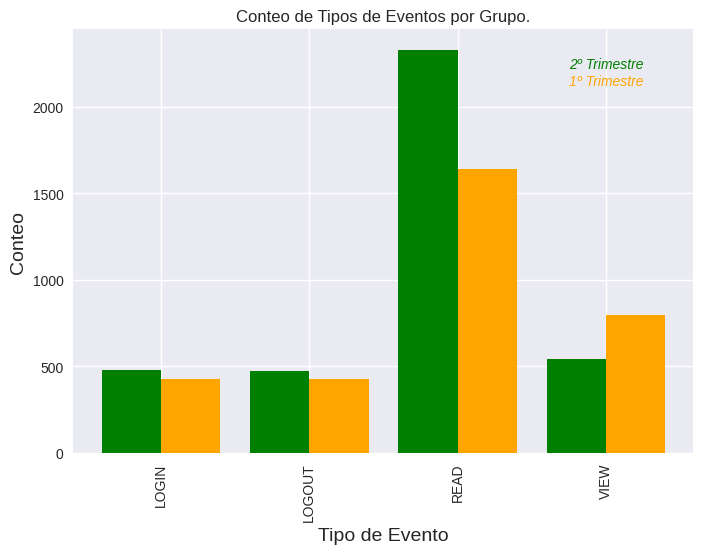

In [118]:
plt.style.use('seaborn')
ax = dif_eventos_exp['USERID'].plot(kind="bar", width=-0.4, rot=0, stacked=True, align='edge', color="green")
dif_eventos_ctrl1_2['USERID'].plot(ax=ax, width=0.4, kind="bar",align='edge', color="orange")
ax.set_xticklabels(dif_eventos_exp['TIPO EVENTO'])
ax.set_ylabel('Conteo', fontsize = 14)
ax.set_xlabel('Tipo de Evento', fontsize = 14)
# ax.legend(title='DataFrame')
ax.set_title('Conteo de Tipos de Eventos por Grupo.')
ax.text(3, 2150, "1º Trimestre",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "orange",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
ax.text(3, 2250, "2º Trimestre",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "green",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
plt.autoscale(enable=True, axis='x')
plt.show()

Vamos a contemplar que el grupo experimental es el 100% (la totalidad) para ver las diferencias porcentuales con el grupo de control.

Y sacamos en otra frase a qué número exacto corresponden estos porcentajes.

In [119]:
# Grupo exp como ctrl_2
for i in range(len(dif_eventos_exp)):
  porcentaje = round((dif_eventos_ctrl1_2['USERID'].iloc[i-1]*100)/dif_eventos_exp['USERID'].iloc[i-1],2)
  print('El evento', dif_eventos_exp['TIPO EVENTO'].iloc[i-1], 'del grupo experimental como grupo de control supone un ', porcentaje, '% siendo el 100 % lo recogido en el grupo experimental.')
  print('Que se corresponde con', dif_eventos_ctrl1_2['USERID'].iloc[i-1],'registros obtenidos del grupo como control y', dif_eventos_exp['USERID'].iloc[i-1], 'del grupo como experimental.\n')

El evento VIEW del grupo experimental como grupo de control supone un  146.88 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 799 registros obtenidos del grupo como control y 544 del grupo como experimental.

El evento LOGIN del grupo experimental como grupo de control supone un  89.96 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 430 registros obtenidos del grupo como control y 478 del grupo como experimental.

El evento LOGOUT del grupo experimental como grupo de control supone un  89.89 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 427 registros obtenidos del grupo como control y 475 del grupo como experimental.

El evento READ del grupo experimental como grupo de control supone un  70.31 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 1639 registros obtenidos del grupo como control y 2331 del grupo como experimental.



###Diferencias Tipo Evento - Sucursal
Medimos cuál es el impacto, número de veces que se producen, de cada tipo de evento en cada sucursal (por un lado del grupo experimental y por otro del grupo de control).

In [120]:
import plotly.express as px

dif_sucursales_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

OJOOOOO, CAMBIAR LO DE VIEW, HAY QUE SACAR BIEN EL TIPO DE EVENTO Y LA SUCURSAL, EN FUNCIÓN DEL MÁXIMO CONSEGUIDO.

In [121]:
print('El evento con más registros es', max(dif_sucursales_exp['TIPO EVENTO']),'en la sucursal', max(dif_sucursales_exp['SUCURSAL']), 'con un total de', max(dif_sucursales_exp['USERID']))

El evento con más registros es VIEW en la sucursal 0512 - VENTAS con un total de 462


In [122]:
dif_suc_prueba = prueba.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_suc_prueba, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [123]:
dif_sucursales_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

IGUAL QUE ARRIBA, ESTÁ MAAAAAAAAAAAL

In [124]:
print('El evento con más registros es', max(dif_sucursales_ctrl['TIPO EVENTO']),'en la sucursal', max(dif_sucursales_ctrl['SUCURSAL']), 'con un total de', max(dif_sucursales_ctrl['USERID']))

El evento con más registros es VIEW en la sucursal 0718 - VALDEMORO con un total de 297


In [125]:
# Grupo exp como ctrl
dif_sucursales_ctrl1_2 = accesos_gr_ctrl1_2.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_ctrl1_2, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

####Cambio sucursales por puntos de venta
Sacamos el mismo estudio para los puntos de venta (PV) en vez de las sucursales.

In [126]:
dif_PV_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'PV'], as_index=False).count()

fig = px.scatter(dif_PV_exp, y="TIPO EVENTO", x="PV", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Diferencia de accesos por tipología de agente
Medimos cuál es el impacto que tiene cada tipo de agente en los eventos, ¿están accediendo más los agentes en formación (16) o los estándar (37)?

In [127]:
dif_tipologia_prueba = prueba.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()

fig = px.scatter(dif_tipologia_prueba, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [128]:
dif_tipologia_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()

fig = px.scatter(dif_tipologia_exp, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [129]:
dif_tipologia_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()
fig = px.scatter(dif_tipologia_ctrl, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [130]:
# Grupo exp como ctrl
dif_tipologia_ctrl1_2 = accesos_gr_ctrl1_2.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()
fig = px.scatter(dif_tipologia_ctrl1_2, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Agentes en Formación usando los informes
En esta parte del código, vemos qué agentes (del grupo experimental) en formación están usando los informes por sucursal. Código para estar al tanto de cómo ha sido la formación en cascada.

In [131]:
df_for = Gr1[Gr1["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_exp = pd.merge(accesos_usuarios_df, df_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_exp = accesos_for_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes en formación dentro del grupo experimental para saber si están entrando agentes de todas ellas. Observamos que hay 11, luego ya han accedido desde todas.

In [132]:
df_for['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS', '0512 - VENTAS'],
      dtype=object)

####Para el grupo de control
Uso de informes para los agentes en formación del grupo de control. ¿Cuánto usan Callidus los agentes en formación sin informes nuevos relevantes?

In [133]:
df2_for = Gr2[Gr2["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_ctrl = pd.merge(accesos_usuarios_df, df2_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_ctrl = accesos_for_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes en formación dentro del grupo de control para saber si están entrando agentes de todas ellas. Observamos que hay 12 y solo se ha accedido desde 9 **(cambiar diariamente si esto cambia)**.

In [134]:
df2_for['SUCURSAL'].unique()

array(['0018 - ARANJUEZ', '0214 - MOSTOLES', '0218 - FUENLABRADA',
       '0220 - LEGANES', '0221 - ALCORCON', '0223 - PARLA',
       '0255 - GETAFE', '0277 - MADRID-BUENAVISTA', '0312 - VALLECAS',
       '0412 - CARABANCHEL', '0442 - MADRID-CIUDAD DE LOS ANGELES',
       '0718 - VALDEMORO'], dtype=object)

In [135]:
# Grupo exp como ctrl
df1_2_for = Gr1_2[Gr1_2["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_ctrl1_2 = pd.merge(aud_gr1_2, df1_2_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_ctrl1_2 = accesos_for_ctrl1_2.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_ctrl1_2, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

6 sucursales de 11 **(CAMBIAR SI SE COGEN MÁS MESE ATRÁS Y VARÍA)**.

In [136]:
df1_2_for['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS', '0512 - VENTAS'],
      dtype=object)

###Agentes Estándar usando los informes
En esta parte del código, vemos qué agentes (del grupo experimental) de tipo estándar, están usando los informes por sucursal. Código para comparar con los de formación y ver si es mejor contar de primera mano la información o la formación en cascada y, medir qué tipología de agente encuentra más relevante los informes.

In [137]:
df_est_prueba = Gr2[Gr2["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_prueba = pd.merge(aud_gr1_2, df_est_prueba, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_prueba = accesos_est_prueba.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_prueba, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [138]:
df_est = Gr1[Gr1["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_exp = pd.merge(accesos_usuarios_df, df_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_exp = accesos_est_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes estándar dentro del grupo experimental para saber si están entrando agentes de todas ellas. Observamos que hay 10, ya han entrado todos.

In [139]:
df_est['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS'], dtype=object)

Voy a sacar el número de agentes que hay en esta sucursal, para saber si es importante esta falta de accesos o no. Hay dos agentes en esta sucursal, no supone mucho impacto.

In [140]:
# vaguada_est = df_est[df_est['SUCURSAL'].str.contains('VAGUADA')]

# vaguada_est

####Para el grupo de control
Uso de informes para los agentes estándar del grupo de control. ¿Cuánto usan Callidus estos agentes sin informes nuevos relevantes? ¿Usan Callidus como herramienta de ayuda?

In [141]:
df2_est = Gr2[Gr2["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_ctrl = pd.merge(accesos_usuarios_df, df2_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_ctrl = accesos_est_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes estándar dentro del grupo de control para saber si están entrando agentes de todas ellas. Observamos que hay 11 y solo se ha accedido desde 9 sucursales **(cambiar si se modifica)**.

In [142]:
df2_est['SUCURSAL'].unique()

array(['0214 - MOSTOLES', '0218 - FUENLABRADA', '0220 - LEGANES',
       '0221 - ALCORCON', '0223 - PARLA', '0255 - GETAFE',
       '0277 - MADRID-BUENAVISTA', '0312 - VALLECAS',
       '0412 - CARABANCHEL', '0442 - MADRID-CIUDAD DE LOS ANGELES'],
      dtype=object)

In [143]:
# Grupo exp como ctrl
df1_2_est = Gr1_2[Gr1_2["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_ctrl1_2 = pd.merge(aud_gr1_2, df1_2_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_ctrl1_2 = accesos_est_ctrl1_2.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_ctrl1_2, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Impacto por agente
¿Cuántos agentes del grupo experimental están haciendo uso de los informes? ¿Cuáles de ellos acceden a Callidus? ¿Es un número alto?

Primero para los agentes en formación del grupo experimental.

In [144]:
agentes_est_prueba = prueba.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_prueba, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [145]:
agentes_for_exp = accesos_for_exp.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_exp, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [146]:
# # CODIGO PARA ENCONTRAR AGENTES CONCRETOS
# agente = Gr2[Gr2["NOMBRE"].str.contains("ALICIA")]
# agente

In [147]:
agentes_est_exp = accesos_est_exp.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_exp, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

Agentes por sucursal, formación y estándar juntos.

In [205]:
agentes_for_exp = accesos_for_exp.groupby(by=['NOMBRE USUARIO', 'SUCURSAL'], as_index=False).count()
agentes_est_exp = accesos_est_exp.groupby(by=['NOMBRE USUARIO', 'SUCURSAL'], as_index=False).count()
agentes_for_ctrl = accesos_for_ctrl.groupby(by=['NOMBRE USUARIO', 'SUCURSAL'], as_index=False).count()
agentes_est_ctrl = accesos_est_ctrl.groupby(by=['NOMBRE USUARIO', 'SUCURSAL'], as_index=False).count()

import plotly.graph_objects as go

fig = go.Figure()

# Añadir la primera traza para los datos del establecimiento
fig.add_trace(go.Scatter(
    x=agentes_est_exp['SUCURSAL'],
    y=agentes_est_exp['USERID'],
    mode='markers',  # Modo de puntos
    marker=dict(size=8, color='blue'),  # Controlar el tamaño y color de los puntos
    name='ESTÁNDAR EXP'  # Nombre de la leyenda
))

# Añadir la segunda traza para los datos foráneos
fig.add_trace(go.Scatter(
    x=agentes_for_exp['SUCURSAL'],
    y=agentes_for_exp['USERID'],
    mode='markers',
    marker=dict(size=8, color='red'),  # Otro color
    name='FORMACIÓN EXP'
))

# Añadir la segunda traza para los datos foráneos
fig.add_trace(go.Scatter(
    x=agentes_for_ctrl['SUCURSAL'],
    y=agentes_for_ctrl['USERID'],
    mode='markers',
    marker=dict(size=8, color='red', symbol='x'),  # Otro color
    name='FORMACIÓN CTRL'
))

# Añadir la segunda traza para los datos foráneos
fig.add_trace(go.Scatter(
    x=agentes_est_ctrl['SUCURSAL'],
    y=agentes_est_ctrl['USERID'],
    mode='markers',
    marker=dict(size=8, color='blue', symbol='x'),  # Otro color
    name='ESTÁNDAR CTRL'
))

# Actualizar el layout para añadir título y mejorar la presentación
fig.update_layout(
    title='Accesos Grupo Experimental por Usuario y Sucursal',
    xaxis_title='Sucursal',
    yaxis_title='Número de Accesos',
    legend_title='Tipo de Usuario'
)

# Mostrar el gráfico
fig.show()

Cuántos agentes están usando los informes, por tipología y en su totalidad.

Totalidad de agentes en el grupo experimental y según la tipología.

In [149]:
print('Hay', agentes_for_exp['NOMBRE USUARIO'].nunique(), 'agentes en formación del grupo experimental usando los informes y', agentes_est_exp['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_exp['NOMBRE USUARIO'].nunique() + agentes_est_exp['NOMBRE USUARIO'].nunique(), 'agentes.')
print('Hay', df_for['NOMBRE'].nunique(), 'agentes en formación y', df_est['NOMBRE'].nunique(), 'agentes estándar en el grupo experimental, es decir, un total de', df_for['NOMBRE'].nunique() + df_est['NOMBRE'].nunique(), 'agentes.')

Hay 27 agentes en formación del grupo experimental usando los informes y 21 agentes estándar, es decir, un total de 48 agentes.
Hay 51 agentes en formación y 28 agentes estándar en el grupo experimental, es decir, un total de 79 agentes.


Medimos porcentualmente qué representan estos datos.

In [150]:
dif_for_exp = round((100*agentes_for_exp['NOMBRE USUARIO'].nunique())/df_for['NOMBRE'].nunique(),2)

dif_est_exp = round((100*agentes_est_exp['NOMBRE USUARIO'].nunique())/df_est['NOMBRE'].nunique(),2)

total_usando = agentes_for_exp['NOMBRE USUARIO'].nunique() + agentes_est_exp['NOMBRE USUARIO'].nunique()
total_exp = (df_for['NOMBRE'].nunique() + df_est['NOMBRE'].nunique())

dif_total_exp = round((100*total_usando)/total_exp,2)

print('Hay', dif_for_exp, '% de agentes en formación y', dif_est_exp, '% agentes estándar usando los informes, es decir, un total de', dif_total_exp, '% de agentes.')

Hay 52.94 % de agentes en formación y 75.0 % agentes estándar usando los informes, es decir, un total de 60.76 % de agentes.


####Para el grupo de control

In [151]:
agentes_for_ctrl = accesos_for_ctrl.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_ctrl, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [152]:
agentes_est_ctrl = accesos_est_ctrl.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_ctrl, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [153]:
agente = Gr2[Gr2["NOMBRE"].str.contains("IRENE")]
agente

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA


In [154]:
print('Hay', agentes_for_ctrl['NOMBRE USUARIO'].nunique(), 'agentes en formación usando Callidus del grupo de control y', agentes_est_ctrl['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_ctrl['NOMBRE USUARIO'].nunique() + agentes_est_ctrl['NOMBRE USUARIO'].nunique(), 'agentes.')
print('Hay', df2_for['NOMBRE'].nunique(), 'agentes en formación y', df2_est['NOMBRE'].nunique(), 'agentes estándar en el grupo de control, es decir, un total de', df2_for['NOMBRE'].nunique() + df2_est['NOMBRE'].nunique(), 'agentes.')

Hay 27 agentes en formación usando Callidus del grupo de control y 15 agentes estándar, es decir, un total de 42 agentes.
Hay 65 agentes en formación y 18 agentes estándar en el grupo de control, es decir, un total de 83 agentes.


Medimos los porcentajes.

In [155]:
dif_for_ctrl = round((100*agentes_for_ctrl['NOMBRE USUARIO'].nunique())/df2_for['NOMBRE'].nunique(),2)

dif_est_ctrl = round((100*agentes_est_ctrl['NOMBRE USUARIO'].nunique())/df2_est['NOMBRE'].nunique(),2)

total_usando_ctrl = agentes_for_ctrl['NOMBRE USUARIO'].nunique() + agentes_est_ctrl['NOMBRE USUARIO'].nunique()
total_ctrl = (df2_for['NOMBRE'].nunique() + df2_est['NOMBRE'].nunique())

dif_total_ctrl = round((100*total_usando_ctrl)/total_ctrl,2)

print('Hay', dif_for_ctrl, '% de agentes en formación y', dif_est_ctrl, '% agentes estándar usando Callidus del grupo de control, es decir, un total de', dif_total_ctrl, '% de agentes.')

Hay 41.54 % de agentes en formación y 83.33 % agentes estándar usando Callidus del grupo de control, es decir, un total de 50.6 % de agentes.


In [156]:
# Grupo exp como ctrl
agentes_for_ctrl1_2 = accesos_for_ctrl1_2.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_ctrl1_2, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [157]:
# Grupo exp como ctrl
agentes_est_ctrl1_2 = accesos_est_ctrl1_2.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_ctrl1_2, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [158]:
print('Hay', agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique(), 'agentes en formación usando Callidus del grupo experimental como grupo de control y', agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique() + agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique(), 'agentes.')
print('Hay', df1_2_for['NOMBRE'].nunique(), 'agentes en formación y', df1_2_est['NOMBRE'].nunique(), 'agentes estándar en el grupo experimental como grupo de control, es decir, un total de', df1_2_for['NOMBRE'].nunique() + df1_2_est['NOMBRE'].nunique(), 'agentes.')

Hay 27 agentes en formación usando Callidus del grupo experimental como grupo de control y 25 agentes estándar, es decir, un total de 52 agentes.
Hay 51 agentes en formación y 28 agentes estándar en el grupo experimental como grupo de control, es decir, un total de 79 agentes.


In [159]:
dif_for_ctrl1_2 = round((100*agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique())/df1_2_for['NOMBRE'].nunique(),2)

dif_est_ctrl1_2 = round((100*agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique())/df1_2_est['NOMBRE'].nunique(),2)

total_usando_ctrl1_2 = agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique() + agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique()
total_ctrl1_2 = (df1_2_for['NOMBRE'].nunique() + df1_2_est['NOMBRE'].nunique())

dif_total_ctrl1_2 = round((100*total_usando_ctrl1_2)/total_ctrl1_2,2)

print('Hay', dif_for_ctrl1_2, '% de agentes en formación y', dif_est_ctrl1_2, '% agentes estándar usando Callidus del grupo experimental como control, es decir, un total de', dif_total_ctrl1_2, '% de agentes.')

Hay 52.94 % de agentes en formación y 89.29 % agentes estándar usando Callidus del grupo experimental como control, es decir, un total de 65.82 % de agentes.


###Medimos las Bajas
Vamos a ver los agentes de ambos grupos que se han dado de baja hasta el momento, a partir del 1.18 la parte de agentes inactivos que será subida diariamente.

####Bajas de los agentes del grupo experimental

In [160]:
bajas_exp = Gr1[Gr1['NOMBRE'].isin(bajas['NOMBRE'].unique())]

bajas_exp

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA
1184,0004 - ALCALA DE HENARES,0004 - ALCALA DE HENARES,4,2444,09249523G0000,09249523G0000,09249523G,HUGO VALLE PEREZ,16 - AGENTE EN FORMACION,2023-10-05
1186,0004 - ALCALA DE HENARES,0004 - ALCALA DE HENARES,4,2446,09026229V0000,09026229V0000,09026229V,MARIA RUTH MARTIN HIDALGO,16 - AGENTE EN FORMACION,2023-12-07
1188,0004 - ALCALA DE HENARES,0004 - ALCALA DE HENARES,4,2448,Y8838814C0000,Y8838814C0000,Y8838814C,YANNERIS FERNANDEZ RODRIGUEZ,16 - AGENTE EN FORMACION,2024-01-16
1597,0212 - MADRID-G.B.,0212 - MADRID-G.B.,212,9747,60142919N0000,60142919N0000,60142919N,YHORUSKA GIONNELLY CASTRO LOVERA,16 - AGENTE EN FORMACION,2023-09-19
1896,0234 - COSLADA,0427 - ARGANDA DEL REY,427,6362,Y7722758Q0000,Y7722758Q0000,Y7722758Q,OLGA ELISA CHAVARRI,16 - AGENTE EN FORMACION,2024-03-19
2287,0512 - VENTAS,0512 - VENTAS,512,9599,Z0921459S0000,Z0921459S0000,Z0921459S,DEIVIS ABRAHAM SERRA RANGEL,16 - AGENTE EN FORMACION,2024-02-01


#####Porcentaje Bajas
A qué porcentaje corresponde el número de bajas, contando con que el total es el número inicial de agentes que había en el grupo experimental.

In [161]:
agentes_actuales_exp = Gr1.shape[0] - bajas_exp.shape[0]
print('El número total de agentes inicial en el grupo era de', Gr1.shape[0], 'agentes y se han dado de baja', bajas_exp.shape[0], 'por lo que quedan', agentes_actuales_exp, 'agentes.')
print('Esto se corresponde a un', round((bajas_exp.shape[0]*100)/Gr1.shape[0], 2), '% de bajas, quedando un', round((agentes_actuales_exp*100)/Gr1.shape[0], 2),'% del 100 % inicial.')

El número total de agentes inicial en el grupo era de 79 agentes y se han dado de baja 6 por lo que quedan 73 agentes.
Esto se corresponde a un 7.59 % de bajas, quedando un 92.41 % del 100 % inicial.


####Bajas de los agentes del grupo de control

In [162]:
bajas_ctrl = Gr2[Gr2['NOMBRE'].isin(bajas['NOMBRE'].unique())]

bajas_ctrl

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA
5,0214 - MOSTOLES,0214 - MOSTOLES,214,9699,47285226D0000,47285226D0000,47285226D,PABLO GARCIA DE LA INFANTA CARPIO,16 - AGENTE EN FORMACION,2023-09-12
6,0214 - MOSTOLES,0214 - MOSTOLES,214,9705,47475187J0000,47475187J0000,47475187J,KEVIN TRYCHAN AGUILAR,16 - AGENTE EN FORMACION,2024-03-18
10,0218 - FUENLABRADA,0218 - FUENLABRADA,218,9007,02331742W0000,02331742W0000,02331742W,MARIA ARACELI JIMENEZ JIMENEZ,16 - AGENTE EN FORMACION,2024-03-18
18,0220 - LEGANES,0220 - LEGANES,220,9000,14077527D0000,14077527D0000,14077527D,YRIS DEL CARMEN GAMBOA GONZALEZ,16 - AGENTE EN FORMACION,2024-03-18
30,0221 - ALCORCON,0221 - ALCORCON,221,9741,70825956D0000,70825956D0000,70825956D,BEATRIZ CISNEROS MATE,16 - AGENTE EN FORMACION,2024-04-03
65,0442 - MADRID-CIUDAD DE LOS ANGELES,0442 - MADRID-CIUDAD DE LOS ANGELES,442,9763,05318739N0000,05318739N0000,05318739N,JAVIER TRABANCA PELAYO,16 - AGENTE EN FORMACION,2023-12-04
72,0442 - MADRID-CIUDAD DE LOS ANGELES,0442 - MADRID-CIUDAD DE LOS ANGELES,442,9772,Z1039821L0000,Z1039821L0000,Z1039821L,MAYRA BIANCA LACROUX GARCIA,16 - AGENTE EN FORMACION,2024-02-22


#####Porcentaje Bajas
A qué porcentaje corresponde el número de bajas, contando con que el total es el número inicial de agentes que había en el grupo de control.

In [163]:
agentes_actuales_ctrl = Gr2.shape[0] - bajas_ctrl.shape[0]
print('El número total de agentes inicial en el grupo era de', Gr2.shape[0], 'agentes y se han dado de baja', bajas_ctrl.shape[0], 'por lo que quedan', agentes_actuales_ctrl, 'agentes.')
print('Esto se corresponde a un', round((bajas_ctrl.shape[0]*100)/Gr2.shape[0], 2), '% de bajas, quedando un', round((agentes_actuales_ctrl*100)/Gr2.shape[0], 2),'% del 100 % inicial.')

El número total de agentes inicial en el grupo era de 83 agentes y se han dado de baja 7 por lo que quedan 76 agentes.
Esto se corresponde a un 8.43 % de bajas, quedando un 91.57 % del 100 % inicial.


###Medición de la Producción


####Pólizas Físicas y Corregidas
Comenzamos a medir las pólizas (tanto físicas como corregidas) de los agentes del grupo experimental, el de control y la producción del grupo experimental en los meses del primer trimestre.

#####Grupo Experimental (1º Trim VS 2º Trim)

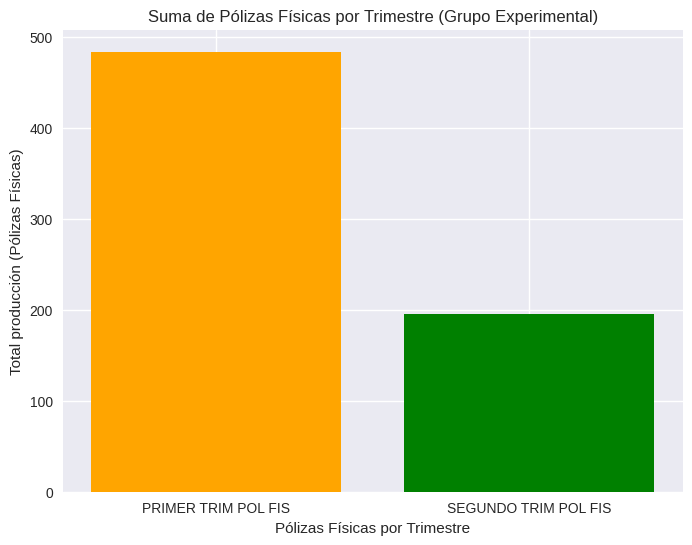

In [164]:
prod_fis_corr_exp = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(Gr1['LDAP'].unique())]

suma_fis_trim1 = prod_fis_corr_exp['PRIMER TRIM POL FIS'].sum()
suma_fis_trim2 = prod_fis_corr_exp['SEGUNDO TRIM POL FIS'].sum()

# Preparar datos para el gráfico
sumas_fis = [suma_fis_trim1, suma_fis_trim2]
columnas_fis = ['PRIMER TRIM POL FIS', 'SEGUNDO TRIM POL FIS']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis, sumas_fis, color=['orange', 'green'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Experimental)')
plt.show()

In [165]:
print('En el primer trimestre el grupo experimental hizo', suma_fis_trim1,'pólizas físicas, mientras que en el segundo', suma_fis_trim2,'.')
print('En el primer trimestre el grupo experimental hizo un 100 % pólizas físicas, mientras que en el segundo', round((100*suma_fis_trim2)/suma_fis_trim1,2),'%.')

En el primer trimestre el grupo experimental hizo 484 pólizas físicas, mientras que en el segundo 195 .
En el primer trimestre el grupo experimental hizo un 100 % pólizas físicas, mientras que en el segundo 40.29 %.


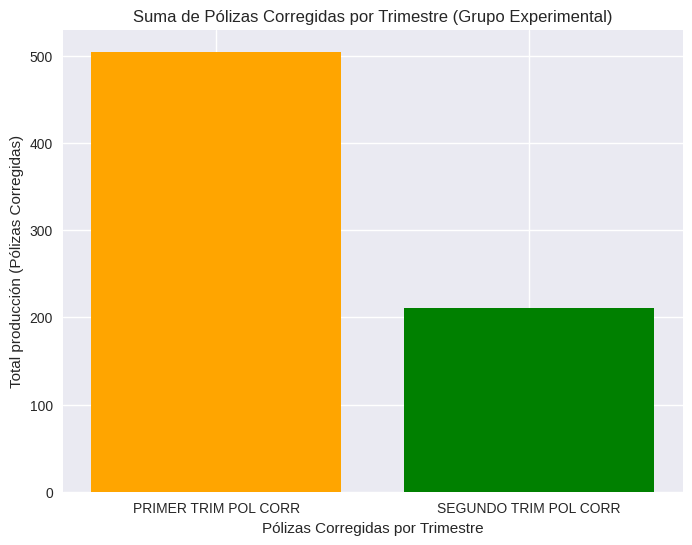

In [166]:
suma_corr_trim1 = prod_fis_corr_exp['PRIMER TRIM POL CORR'].sum()
suma_corr_trim2 = prod_fis_corr_exp['SEGUNDO TRIM POL CORR'].sum()

# Preparar datos para el gráfico
sumas_corr = [suma_corr_trim1, suma_corr_trim2]
columnas_corr = ['PRIMER TRIM POL CORR', 'SEGUNDO TRIM POL CORR']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr, sumas_corr, color=['orange', 'green'])
plt.xlabel('Pólizas Corregidas por Trimestre')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Trimestre (Grupo Experimental)')
plt.show()

In [167]:
print('En el primer trimestre el grupo experimental hizo', round(suma_corr_trim1),'pólizas corregidas, mientras que en el segundo', round(suma_corr_trim2,2),'.')
print('En el primer trimestre el grupo experimental hizo un 100 % pólizas corregidas, mientras que en el segundo', round((100*suma_corr_trim2)/suma_corr_trim1,2),'%.')

En el primer trimestre el grupo experimental hizo 505 pólizas corregidas, mientras que en el segundo 211.09 .
En el primer trimestre el grupo experimental hizo un 100 % pólizas corregidas, mientras que en el segundo 41.83 %.


#####Grupo de Control (1º Trim VS 2º Trim)

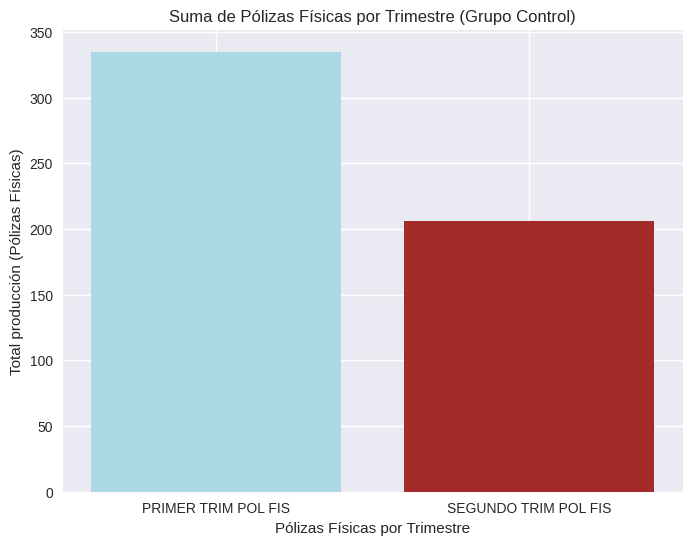

In [168]:
prod_fis_corr_ctrl = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(Gr2['LDAP'].unique())]

suma_fis_trim1_ctrl = prod_fis_corr_ctrl['PRIMER TRIM POL FIS'].sum()
suma_fis_trim2_ctrl = prod_fis_corr_ctrl['SEGUNDO TRIM POL FIS'].sum()

# Preparar datos para el gráfico
sumas_fis_ctrl = [suma_fis_trim1_ctrl, suma_fis_trim2_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis, sumas_fis_ctrl, color=['lightblue', 'brown'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Control)')
plt.show()

Comparamos los valores y contemplando que las del primer trimestre corresponden al 100% sacamos los porcentajes.

In [169]:
print('En el primer trimestre el grupo de control hizo', suma_fis_trim1_ctrl,'pólizas físicas, mientras que en el segundo', suma_fis_trim2_ctrl,'.')
print('En el primer trimestre el grupo de control hizo un 100 % pólizas físicas, mientras que en el segundo', round((100*suma_fis_trim2_ctrl)/suma_fis_trim1_ctrl,2),'%.')

En el primer trimestre el grupo de control hizo 335 pólizas físicas, mientras que en el segundo 206 .
En el primer trimestre el grupo de control hizo un 100 % pólizas físicas, mientras que en el segundo 61.49 %.


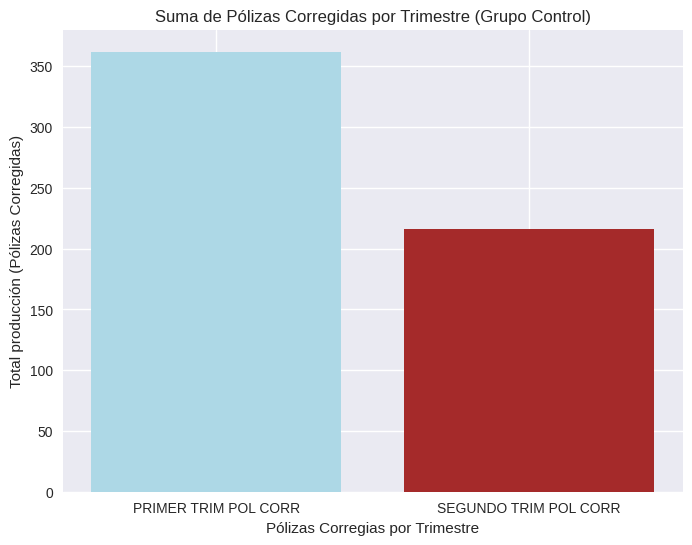

In [170]:
suma_corr_trim1_ctrl = prod_fis_corr_ctrl['PRIMER TRIM POL CORR'].sum()
suma_corr_trim2_ctrl = prod_fis_corr_ctrl['SEGUNDO TRIM POL CORR'].sum()

# Preparar datos para el gráfico
sumas_corr_ctrl = [suma_corr_trim1_ctrl, suma_corr_trim2_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr, sumas_corr_ctrl, color=['lightblue', 'brown'])
plt.xlabel('Pólizas Corregias por Trimestre')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Trimestre (Grupo Control)')
plt.show()

In [171]:
print('En el primer trimestre el grupo de control hizo', round(suma_corr_trim1_ctrl,2),'pólizas corregidas, mientras que en el segundo', round(suma_corr_trim2_ctrl,2),'.')
print('En el primer trimestre el grupo de control hizo un 100 % pólizas corregidas, mientras que en el segundo', round((100*suma_corr_trim2_ctrl)/suma_corr_trim1_ctrl,2),'%.')

En el primer trimestre el grupo de control hizo 362.0 pólizas corregidas, mientras que en el segundo 216.47 .
En el primer trimestre el grupo de control hizo un 100 % pólizas corregidas, mientras que en el segundo 59.8 %.


#####Segundo Trimestre (Experimental VS Control)

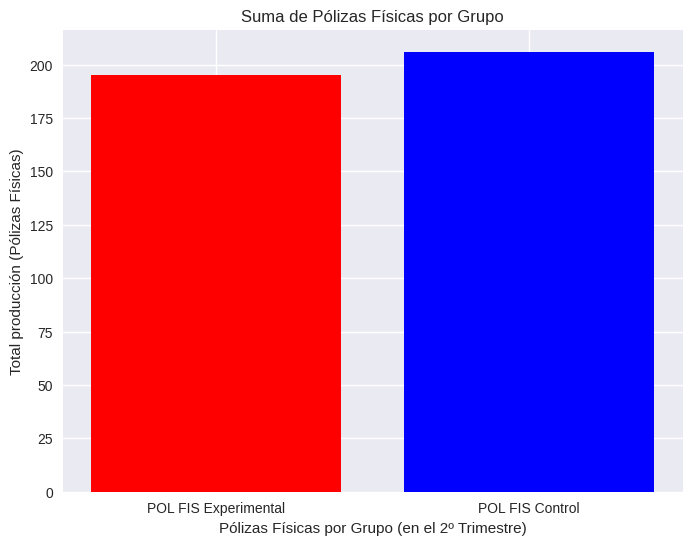

In [172]:
# Preparar datos para el gráfico
sumas_fis_comparativa = [suma_fis_trim2, suma_fis_trim2_ctrl]
columnas_fis_comparativa = ['POL FIS Experimental', 'POL FIS Control']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis_comparativa, sumas_fis_comparativa, color=['red', 'blue'])
plt.xlabel('Pólizas Físicas por Grupo (en el 2º Trimestre)')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Grupo')
plt.show()

In [173]:
print('En el segundo trimestre el grupo de control hizo', round(suma_fis_trim2_ctrl,2),'pólizas físicas, mientras que el experimental', round(suma_fis_trim2,2),'.')
print('El grupo de control hizo un 100 % pólizas físicas, mientras que el experimental', round((100*suma_fis_trim2)/suma_fis_trim2_ctrl,2),'%.')

En el segundo trimestre el grupo de control hizo 206 pólizas físicas, mientras que el experimental 195 .
El grupo de control hizo un 100 % pólizas físicas, mientras que el experimental 94.66 %.


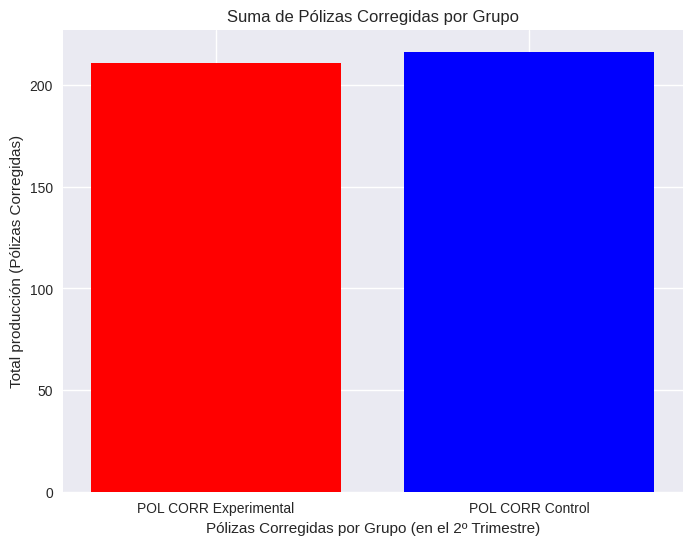

In [174]:
# Preparar datos para el gráfico
sumas_corr_comparativa = [suma_corr_trim2, suma_corr_trim2_ctrl]
columnas_corr_comparativa = ['POL CORR Experimental', 'POL CORR Control']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr_comparativa, sumas_corr_comparativa, color=['red', 'blue'])
plt.xlabel('Pólizas Corregidas por Grupo (en el 2º Trimestre)')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Grupo')
plt.show()

In [175]:
print('En el segundo trimestre el grupo de control hizo', round(suma_corr_trim2_ctrl,2),'pólizas corregidas, mientras que el experimental', round(suma_corr_trim2,2),'.')
print('El grupo de control hizo un 100 % pólizas corregidas, mientras que el experimental', round((100*suma_corr_trim2)/suma_corr_trim2_ctrl,2),'%.')

En el segundo trimestre el grupo de control hizo 216.47 pólizas corregidas, mientras que el experimental 211.09 .
El grupo de control hizo un 100 % pólizas corregidas, mientras que el experimental 97.51 %.


####Pólizas Físicas y Corregidas - Media mensual
Se procede a realizar el estudio de manera mensual con las medias, teniendo en cuenta los agentes que hay en el mes (teniendo en cuenta los agentes que no estuvieran dados de alta enb el 1er trimestre y las bajas que se vayan produciendo).

In [176]:
enero_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-01-01')]
febrero_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-02-01')]
marzo_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-03-01')]
abril_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-04-01')]
mayo_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-05-01')]
junio_bajas = bajas[bajas['F.BAJA'] <= pd.to_datetime('2024-06-01')]


cod_bajas_enero = enero_bajas['COD.CALL/SOLNET'].tolist()
cod_bajas_febrero = febrero_bajas['COD.CALL/SOLNET'].tolist()
cod_bajas_marzo = marzo_bajas['COD.CALL/SOLNET'].tolist()
cod_bajas_abril = abril_bajas['COD.CALL/SOLNET'].tolist()
cod_bajas_mayo = mayo_bajas['COD.CALL/SOLNET'].tolist()
cod_bajas_junio = junio_bajas['COD.CALL/SOLNET'].tolist()

enero_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-01-01')) & (~Gr1['LDAP'].isin(cod_bajas_enero))]
febrero_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-02-01')) & (~Gr1['LDAP'].isin(cod_bajas_febrero))]
marzo_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-03-01')) & (~Gr1['LDAP'].isin(cod_bajas_marzo))]
abril_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-04-01')) & (~Gr1['LDAP'].isin(cod_bajas_abril))]
mayo_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-05-01')) & (~Gr1['LDAP'].isin(mayo_bajas['COD.CALL/SOLNET']))]
junio_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-06-01')) & (~Gr1['LDAP'].isin(cod_bajas_junio))]


enero_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-01-01')) & (~Gr2['LDAP'].isin(enero_bajas))]
febrero_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-02-01')) & (~Gr2['LDAP'].isin(febrero_bajas))]
marzo_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-03-01')) & (~Gr2['LDAP'].isin(marzo_bajas))]
abril_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-04-01')) & (~Gr2['LDAP'].isin(abril_bajas))]
mayo_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-05-01')) & (~Gr2['LDAP'].isin(mayo_bajas))]
junio_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-06-01')) & (~Gr2['LDAP'].isin(junio_bajas))]

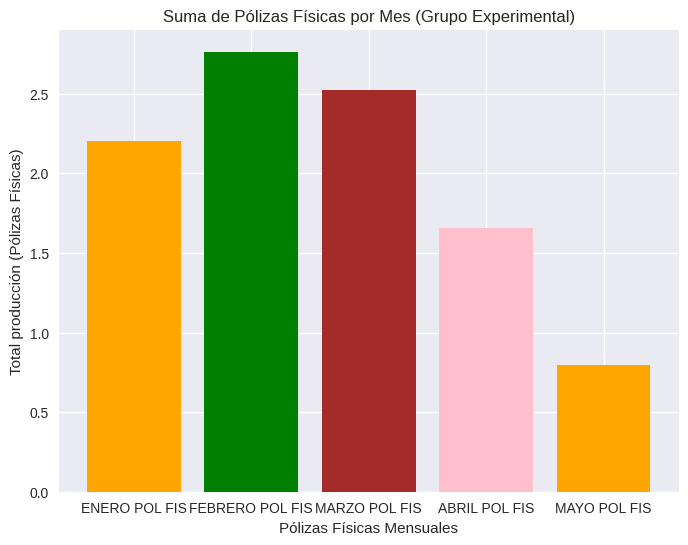

In [179]:
enero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(enero_exp['LDAP'].unique())]
febrero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(febrero_exp['LDAP'].unique())]
marzo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(marzo_exp['LDAP'].unique())]
abril = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(abril_exp['LDAP'].unique())]
mayo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(mayo_exp['LDAP'].unique())]
# junio = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(junio_exp['LDAP'].unique())]

media_fis_enero_exp = enero['POL. FIS. 2024-01'].sum()/enero_exp.shape[0]
media_fis_febrero_exp = febrero['POL. FIS. 2024-02'].sum()/febrero_exp.shape[0]
media_fis_marzo_exp = marzo['POL. FIS. 2024-03'].sum()/marzo_exp.shape[0]
media_fis_abril_exp = abril['POL. FIS. 2024-04'].sum()/abril_exp.shape[0]
media_fis_mayo_exp = mayo['POL. FIS. 2024-05'].sum()/mayo_exp.shape[0]
# media_fis_junio_exp = junio['POL. FIS. 2024-06'].sum()/junio_exp.shape[0]

# # Preparar datos para el gráfico
medias_fis_exp = [media_fis_enero_exp, media_fis_febrero_exp, media_fis_marzo_exp, media_fis_abril_exp, media_fis_mayo_exp]
columnas_fis = ['ENERO POL FIS', 'FEBRERO POL FIS', 'MARZO POL FIS', 'ABRIL POL FIS', 'MAYO POL FIS']
# , 'JUNIO POL FIS']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis, medias_fis_exp, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Pólizas Físicas Mensuales')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Mes (Grupo Experimental)')
plt.show()

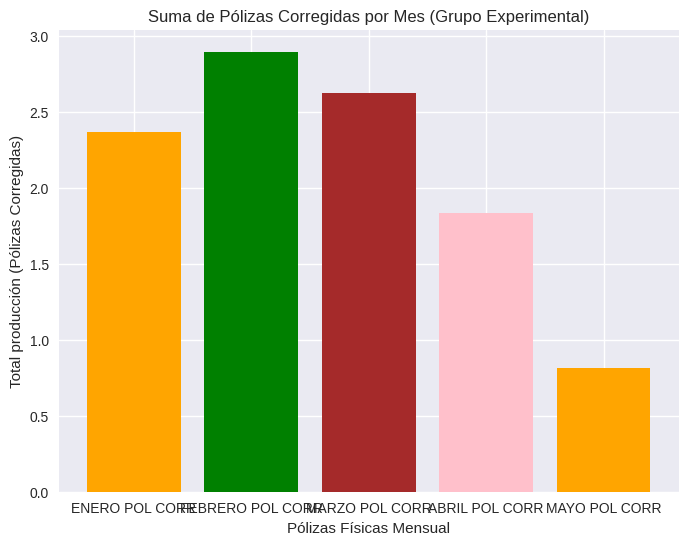

In [180]:
media_corr_enero_exp = enero['POL. CORR. 2024-01'].sum()/enero_exp.shape[0]
media_corr_febrero_exp = febrero['POL. CORR. 2024-02'].sum()/febrero_exp.shape[0]
media_corr_marzo_exp = marzo['POL. CORR. 2024-03'].sum()/marzo_exp.shape[0]
media_corr_abril_exp = abril['POL. CORR. 2024-04'].sum()/abril_exp.shape[0]
media_corr_mayo_exp = mayo['POL. CORR. 2024-05'].sum()/mayo_exp.shape[0]
# media_corr_junio_exp = junio['POL. CORR. 2024-06'].sum()/junio_exp.shape[0]

# # Preparar datos para el gráfico
medias_corr_exp = [media_corr_enero_exp, media_corr_febrero_exp, media_corr_marzo_exp, media_corr_abril_exp, media_corr_mayo_exp]
columnas_corr = ['ENERO POL CORR', 'FEBRERO POL CORR', 'MARZO POL CORR', 'ABRIL POL CORR', 'MAYO POL CORR']
# , 'JUNIO POL CORR']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr, medias_corr_exp, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Pólizas Físicas Mensual')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Mes (Grupo Experimental)')
plt.show()

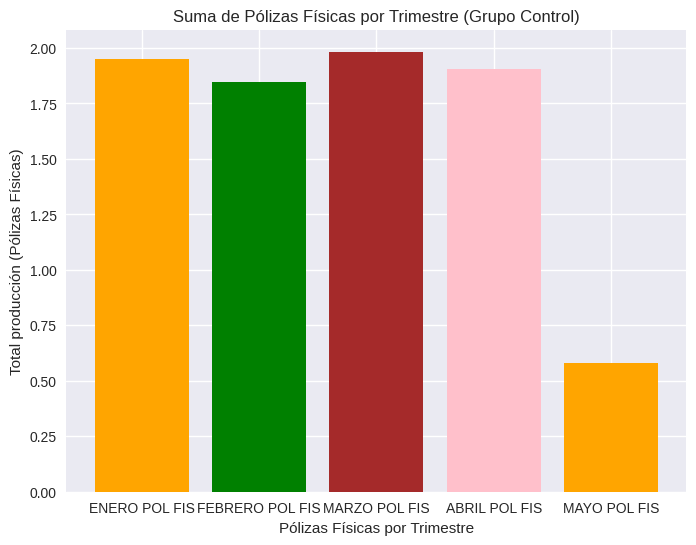

In [181]:
enero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(enero_ctrl['LDAP'].unique())]
febrero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(febrero_ctrl['LDAP'].unique())]
marzo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(marzo_ctrl['LDAP'].unique())]
abril = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(abril_ctrl['LDAP'].unique())]
mayo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(mayo_ctrl['LDAP'].unique())]
# junio = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(junio_ctrl['LDAP'].unique())]

media_fis_enero_ctrl = enero['POL. FIS. 2024-01'].sum()/enero_ctrl.shape[0]
media_fis_febrero_ctrl = febrero['POL. FIS. 2024-02'].sum()/febrero_ctrl.shape[0]
media_fis_marzo_ctrl = marzo['POL. FIS. 2024-03'].sum()/marzo_ctrl.shape[0]
media_fis_abril_ctrl = abril['POL. FIS. 2024-04'].sum()/abril_ctrl.shape[0]
media_fis_mayo_ctrl = mayo['POL. FIS. 2024-05'].sum()/mayo_ctrl.shape[0]
# media_fis_junio_ctrl = junio['POL. FIS. 2024-06'].sum()/junio_ctrl.shape[0]

# # Preparar datos para el gráfico
medias_fis_ctrl = [media_fis_enero_ctrl, media_fis_febrero_ctrl, media_fis_marzo_ctrl, media_fis_abril_ctrl, media_fis_mayo_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis, medias_fis_ctrl, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Control)')
plt.show()

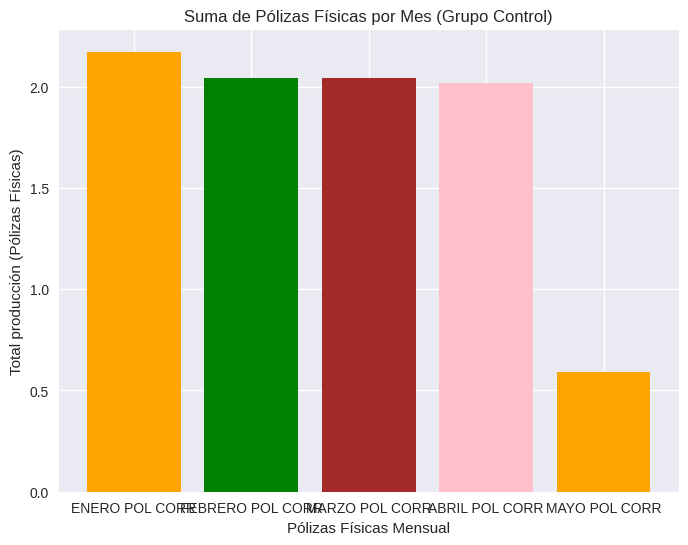

In [182]:
media_corr_enero_ctrl = enero['POL. CORR. 2024-01'].sum()/enero_ctrl.shape[0]
media_corr_febrero_ctrl = febrero['POL. CORR. 2024-02'].sum()/febrero_ctrl.shape[0]
media_corr_marzo_ctrl = marzo['POL. CORR. 2024-03'].sum()/marzo_ctrl.shape[0]
media_corr_abril_ctrl = abril['POL. CORR. 2024-04'].sum()/abril_ctrl.shape[0]
media_corr_mayo_ctrl = mayo['POL. CORR. 2024-05'].sum()/mayo_ctrl.shape[0]
# media_corr_junio_ctrl = junio['POL. CORR. 2024-06'].sum()/junio_ctrl.shape[0]

# # Preparar datos para el gráfico
medias_corr_ctrl = [media_corr_enero_ctrl, media_corr_febrero_ctrl, media_corr_marzo_ctrl, media_corr_abril_ctrl, media_corr_mayo_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr, medias_corr_ctrl, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Pólizas Físicas Mensual')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Mes (Grupo Control)')
plt.show()

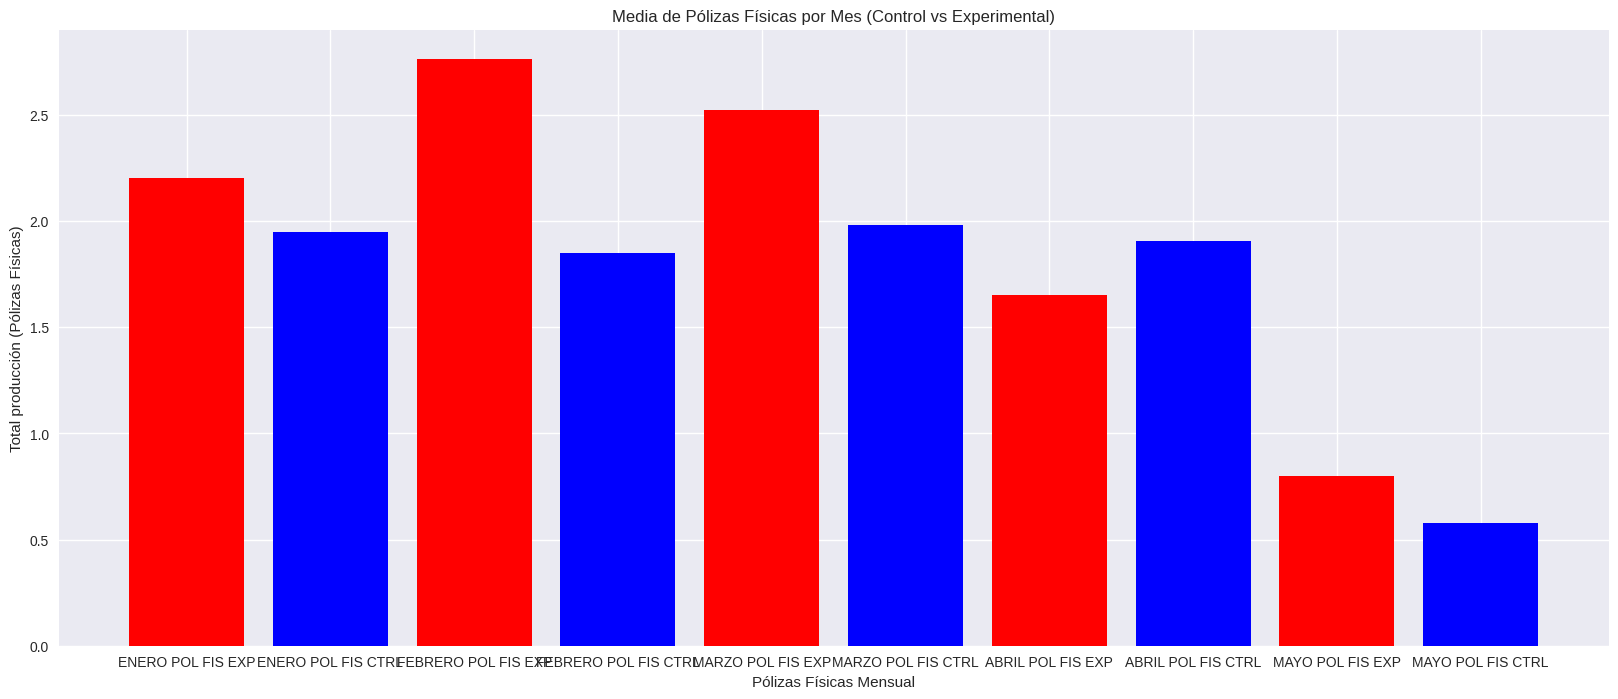

In [183]:
medias_fis = [media_fis_enero_exp, media_fis_enero_ctrl, media_fis_febrero_exp, media_fis_febrero_ctrl, media_fis_marzo_exp, media_fis_marzo_ctrl, media_fis_abril_exp, media_fis_abril_ctrl, media_fis_mayo_exp, media_fis_mayo_ctrl]
columnas_fis_total = ['ENERO POL FIS EXP', 'ENERO POL FIS CTRL', 'FEBRERO POL FIS EXP','FEBRERO POL FIS CTRL', 'MARZO POL FIS EXP', 'MARZO POL FIS CTRL', 'ABRIL POL FIS EXP', 'ABRIL POL FIS CTRL', 'MAYO POL FIS EXP', 'MAYO POL FIS CTRL']
# , 'JUNIO POL FIS EXP', 'JUNIO POL FIS CTRL']
# Crear el gráfico de barras
plt.figure(figsize=(20, 8))
plt.bar(columnas_fis_total, medias_fis, color=['red', 'blue'])
plt.xlabel('Pólizas Físicas Mensual')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Media de Pólizas Físicas por Mes (Control vs Experimental)')
plt.show()

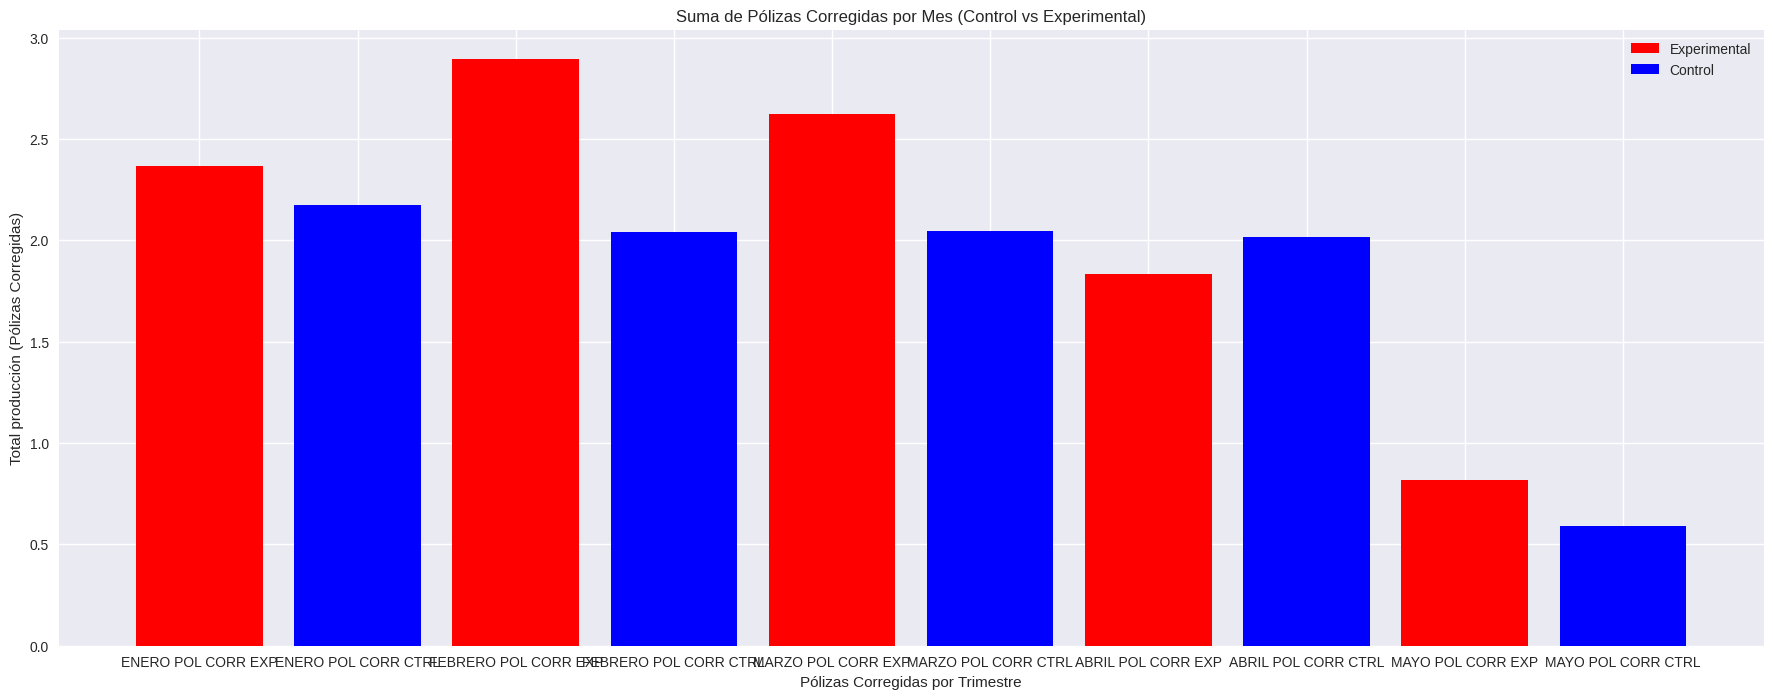

In [184]:
medias_corr = [media_corr_enero_exp, media_corr_enero_ctrl, media_corr_febrero_exp, media_corr_febrero_ctrl, media_corr_marzo_exp, media_corr_marzo_ctrl, media_corr_abril_exp, media_corr_abril_ctrl, media_corr_mayo_exp, media_corr_mayo_ctrl]
columnas_corr_total = ['ENERO POL CORR EXP', 'ENERO POL CORR CTRL', 'FEBRERO POL CORR EXP','FEBRERO POL CORR CTRL', 'MARZO POL CORR EXP', 'MARZO POL CORR CTRL', 'ABRIL POL CORR EXP', 'ABRIL POL CORR CTRL', 'MAYO POL CORR EXP', 'MAYO POL CORR CTRL']
# , 'JUNIO POL CORR EXP', 'JUNIO POL CORR CTRL']

# Crear el gráfico de barras
plt.figure(figsize=(22, 8))
bars = plt.bar(columnas_corr_total, medias_corr, color=['red', 'blue'])
plt.xlabel('Pólizas Corregidas por Trimestre')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Mes (Control vs Experimental)')
plt.legend([bars[0], bars[1]], ['Experimental', 'Control'])
plt.show()

####Tipo de Producción
Vemos si la venta se encamina hacia donde la compañía busca.

In [185]:
enero_prod_esp_exp = pd.merge(prod_enero, enero_exp, on='NIF', how='inner')
febrero_prod_esp_exp = pd.merge(prod_febrero, febrero_exp, on='NIF', how='inner')
marzo_prod_esp_exp = pd.merge(prod_marzo, marzo_exp, on='NIF', how='inner')
abril_prod_esp_exp = pd.merge(prod_abril, abril_exp, on='NIF', how='inner')
mayo_prod_esp_exp = pd.merge(prod_mayo, mayo_exp, on='NIF', how='inner')
# junio_prod_esp_exp = pd.merge(prod_junio, junio_exp, on='NIF', how='inner')

media_hogar_enero_exp = enero_prod_esp_exp['POL. FIS. HOGAR'].sum()/enero_prod_esp_exp.shape[0]
media_rrtt_enero_exp = enero_prod_esp_exp['POL. FIS. RRTT'].sum()/enero_prod_esp_exp.shape[0]
media_rrpp_enero_exp = enero_prod_esp_exp['POL. FIS. RRPP'].sum()/enero_prod_esp_exp.shape[0]
media_aseg_enero_exp = enero_prod_esp_exp['ASEG.'].sum()/enero_prod_esp_exp.shape[0]

media_hogar_febrero_exp = febrero_prod_esp_exp['POL. FIS. HOGAR'].sum()/febrero_prod_esp_exp.shape[0]
media_rrtt_febrero_exp = febrero_prod_esp_exp['POL. FIS. RRTT'].sum()/febrero_prod_esp_exp.shape[0]
media_rrpp_febrero_exp = febrero_prod_esp_exp['POL. FIS. RRPP'].sum()/febrero_prod_esp_exp.shape[0]
media_aseg_febrero_exp = febrero_prod_esp_exp['ASEG.'].sum()/febrero_prod_esp_exp.shape[0]

media_hogar_marzo_exp = marzo_prod_esp_exp['POL. FIS. HOGAR'].sum()/marzo_prod_esp_exp.shape[0]
media_rrtt_marzo_exp = marzo_prod_esp_exp['POL. FIS. RRTT'].sum()/marzo_prod_esp_exp.shape[0]
media_rrpp_marzo_exp = marzo_prod_esp_exp['POL. FIS. RRPP'].sum()/marzo_prod_esp_exp.shape[0]
media_aseg_marzo_exp = marzo_prod_esp_exp['ASEG.'].sum()/marzo_prod_esp_exp.shape[0]

media_hogar_abril_exp = abril_prod_esp_exp['POL. FIS. HOGAR'].sum()/abril_prod_esp_exp.shape[0]
media_rrtt_abril_exp = abril_prod_esp_exp['POL. FIS. RRTT'].sum()/abril_prod_esp_exp.shape[0]
media_rrpp_abril_exp = abril_prod_esp_exp['POL. FIS. RRPP'].sum()/abril_prod_esp_exp.shape[0]
media_aseg_abril_exp = abril_prod_esp_exp['ASEG.'].sum()/abril_prod_esp_exp.shape[0]

media_hogar_mayo_exp = mayo_prod_esp_exp['POL. FIS. HOGAR'].sum()/mayo_prod_esp_exp.shape[0]
media_rrtt_mayo_exp = mayo_prod_esp_exp['POL. FIS. RRTT'].sum()/mayo_prod_esp_exp.shape[0]
media_rrpp_mayo_exp = mayo_prod_esp_exp['POL. FIS. RRPP'].sum()/mayo_prod_esp_exp.shape[0]
media_aseg_mayo_exp = mayo_prod_esp_exp['ASEG.'].sum()/mayo_prod_esp_exp.shape[0]

# media_hogar_junio_exp = junio_prod_esp_exp['POL. FIS. HOGAR'].sum()/junio_prod_esp_exp.shape[0]
# media_rrtt_junio_exp = junio_prod_esp_exp['POL. FIS. RRTT'].sum()/junio_prod_esp_exp.shape[0]
# media_rrpp_junio_exp = junio_prod_esp_exp['POL. FIS. RRPP'].sum()/junio_prod_esp_exp.shape[0]
# media_aseg_junio_exp = junio_prod_esp_exp['ASEG.'].sum()/junio_prod_esp_exp.shape[0]

In [186]:
enero_prod_esp_ctrl = pd.merge(prod_enero, enero_ctrl, on='NIF', how='inner')
febrero_prod_esp_ctrl = pd.merge(prod_febrero, febrero_ctrl, on='NIF', how='inner')
marzo_prod_esp_ctrl = pd.merge(prod_marzo, marzo_ctrl, on='NIF', how='inner')
abril_prod_esp_ctrl = pd.merge(prod_abril, abril_ctrl, on='NIF', how='inner')
mayo_prod_esp_ctrl = pd.merge(prod_mayo, mayo_ctrl, on='NIF', how='inner')
# junio_prod_esp_ctrl = pd.merge(prod_junio, junio_ctrl, on='NIF', how='inner')

media_hogar_enero_ctrl = enero_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/enero_prod_esp_ctrl.shape[0]
media_rrtt_enero_ctrl = enero_prod_esp_ctrl['POL. FIS. RRTT'].sum()/enero_prod_esp_ctrl.shape[0]
media_rrpp_enero_ctrl = enero_prod_esp_ctrl['POL. FIS. RRPP'].sum()/enero_prod_esp_ctrl.shape[0]
media_aseg_enero_ctrl = enero_prod_esp_ctrl['ASEG.'].sum()/enero_prod_esp_ctrl.shape[0]

media_hogar_febrero_ctrl = febrero_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/febrero_prod_esp_ctrl.shape[0]
media_rrtt_febrero_ctrl = febrero_prod_esp_ctrl['POL. FIS. RRTT'].sum()/febrero_prod_esp_ctrl.shape[0]
media_rrpp_febrero_ctrl = febrero_prod_esp_ctrl['POL. FIS. RRPP'].sum()/febrero_prod_esp_ctrl.shape[0]
media_aseg_febrero_ctrl = febrero_prod_esp_ctrl['ASEG.'].sum()/febrero_prod_esp_ctrl.shape[0]

media_hogar_marzo_ctrl = marzo_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/marzo_prod_esp_ctrl.shape[0]
media_rrtt_marzo_ctrl = marzo_prod_esp_ctrl['POL. FIS. RRTT'].sum()/marzo_prod_esp_ctrl.shape[0]
media_rrpp_marzo_ctrl = marzo_prod_esp_ctrl['POL. FIS. RRPP'].sum()/marzo_prod_esp_ctrl.shape[0]
media_aseg_marzo_ctrl = marzo_prod_esp_ctrl['ASEG.'].sum()/marzo_prod_esp_ctrl.shape[0]

media_hogar_abril_ctrl = abril_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/abril_prod_esp_ctrl.shape[0]
media_rrtt_abril_ctrl = abril_prod_esp_ctrl['POL. FIS. RRTT'].sum()/abril_prod_esp_ctrl.shape[0]
media_rrpp_abril_ctrl = abril_prod_esp_ctrl['POL. FIS. RRPP'].sum()/abril_prod_esp_ctrl.shape[0]
media_aseg_abril_ctrl = abril_prod_esp_ctrl['ASEG.'].sum()/abril_prod_esp_ctrl.shape[0]

media_hogar_mayo_ctrl = mayo_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/mayo_prod_esp_ctrl.shape[0]
media_rrtt_mayo_ctrl = mayo_prod_esp_ctrl['POL. FIS. RRTT'].sum()/mayo_prod_esp_ctrl.shape[0]
media_rrpp_mayo_ctrl = mayo_prod_esp_ctrl['POL. FIS. RRPP'].sum()/mayo_prod_esp_ctrl.shape[0]
media_aseg_mayo_ctrl = mayo_prod_esp_ctrl['ASEG.'].sum()/mayo_prod_esp_ctrl.shape[0]

# media_hogar_junio_ctrl = junio_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/junio_prod_esp_ctrl.shape[0]
# media_rrtt_junio_ctrl = junio_prod_esp_ctrl['POL. FIS. RRTT'].sum()/junio_prod_esp_ctrl.shape[0]
# media_rrpp_junio_ctrl = junio_prod_esp_ctrl['POL. FIS. RRPP'].sum()/junio_prod_esp_ctrl.shape[0]
# media_aseg_junio_ctrl = junio_prod_esp_ctrl['ASEG.'].sum()/junio_prod_esp_ctrl.shape[0]

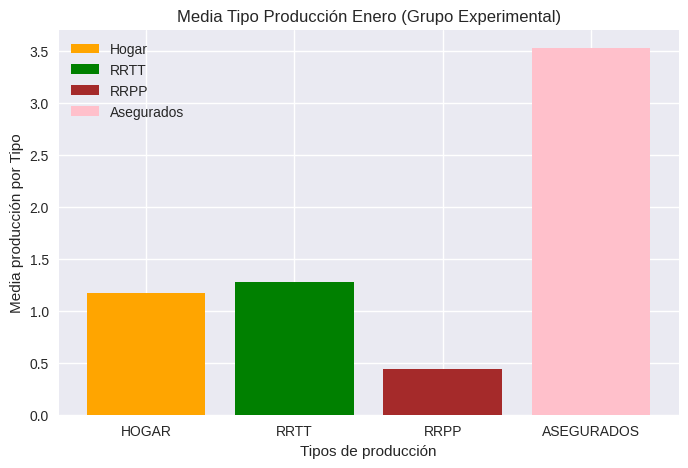

In [187]:
# Preparar datos para el gráfico
medias_enero = [media_hogar_enero_exp, media_rrtt_enero_exp, media_rrpp_enero_exp, media_aseg_enero_exp]
columnas_tipo_prod = ['HOGAR', 'RRTT', 'RRPP', 'ASEGURADOS']

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(columnas_tipo_prod, medias_enero, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Enero (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

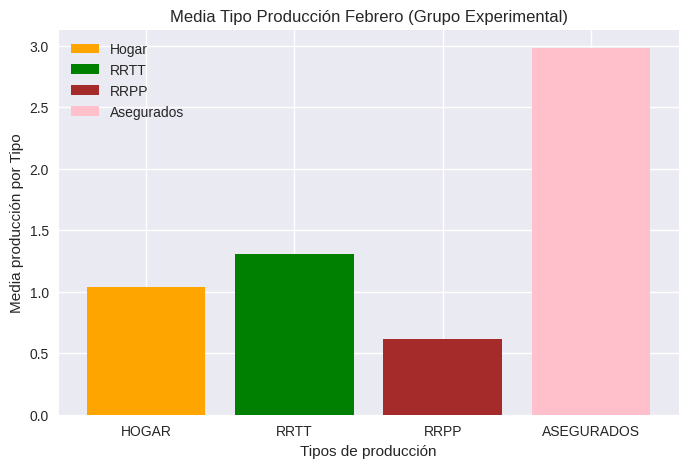

In [188]:
# Preparar datos para el gráfico
medias_febrero = [media_hogar_febrero_exp, media_rrtt_febrero_exp, media_rrpp_febrero_exp, media_aseg_febrero_exp]

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(columnas_tipo_prod, medias_febrero, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Febrero (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

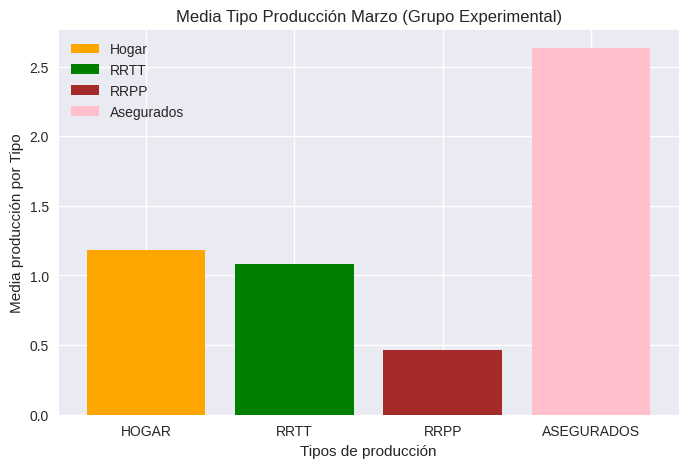

In [189]:
# Preparar datos para el gráfico
medias_marzo = [media_hogar_marzo_exp, media_rrtt_marzo_exp, media_rrpp_marzo_exp, media_aseg_marzo_exp]

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(columnas_tipo_prod, medias_marzo, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Marzo (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

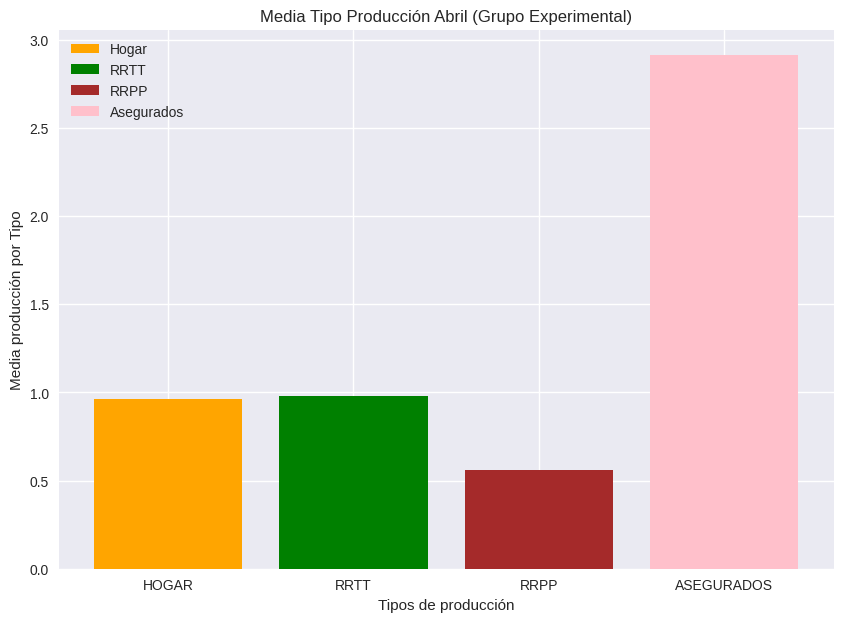

In [190]:
# Preparar datos para el gráfico
medias_abril = [media_hogar_abril_exp, media_rrtt_abril_exp, media_rrpp_abril_exp, media_aseg_abril_exp]

# Crear el gráfico de barras
plt.figure(figsize=(10, 7))
bars = plt.bar(columnas_tipo_prod, medias_abril, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Abril (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

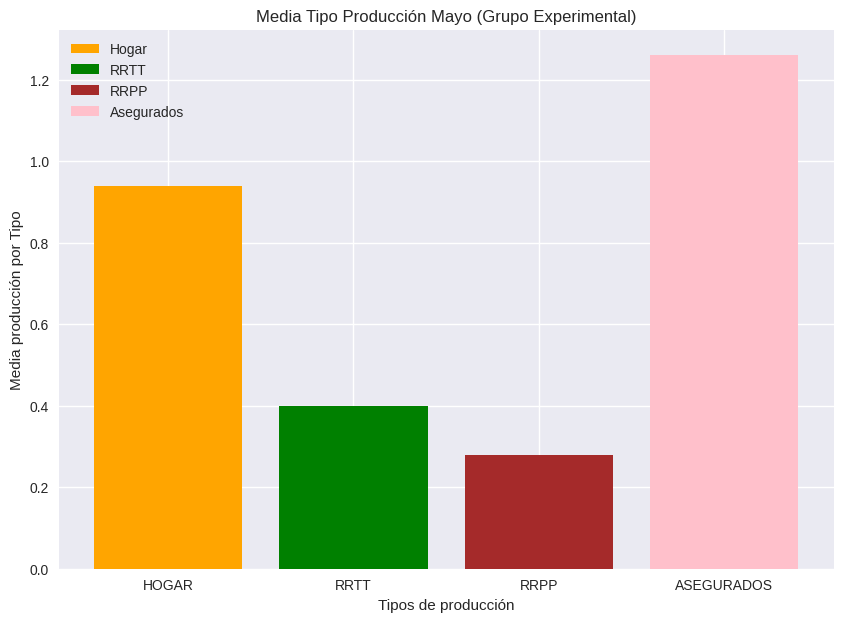

In [191]:
# Preparar datos para el gráfico
medias_mayo = [media_hogar_mayo_exp, media_rrtt_mayo_exp, media_rrpp_mayo_exp, media_aseg_mayo_exp]

# Crear el gráfico de barras
plt.figure(figsize=(10, 7))
bars = plt.bar(columnas_tipo_prod, medias_mayo, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Mayo (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

In [192]:
# # Preparar datos para el gráfico
# medias_junio = [media_hogar_junio_exp, media_rrtt_junio_exp, media_rrpp_junio_exp, media_aseg_junio_exp]

# # Crear el gráfico de barras
# plt.figure(figsize=(10, 7))
# bars = plt.bar(columnas_tipo_prod, medias_junio, color=['orange', 'green', 'brown', 'pink'])
# plt.xlabel('Tipos de producción')
# plt.ylabel('Media producción por Tipo')
# plt.title('Media Tipo Producción Junio (Grupo Experimental)')
# plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
# plt.show()

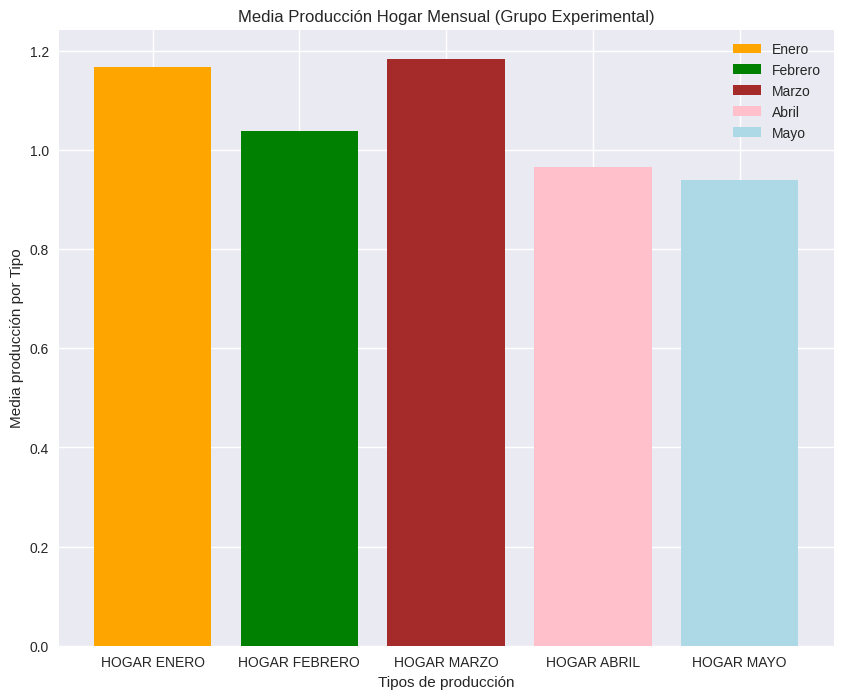

In [193]:
# Preparar datos para el gráfico
medias_hogar_exp = [media_hogar_enero_exp, media_hogar_febrero_exp, media_hogar_marzo_exp, media_hogar_abril_exp, media_hogar_mayo_exp]
# , media_hogar_junio_exp]
columnas_hogar = ['HOGAR ENERO', 'HOGAR FEBRERO', 'HOGAR MARZO', 'HOGAR ABRIL', 'HOGAR MAYO']
# 'HOGAR JUNIO']

# Crear el gráfico de barras
plt.figure(figsize=(10, 8))
bars = plt.bar(columnas_hogar, medias_hogar_exp, color=['orange', 'green', 'brown', 'pink', 'lightblue'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Producción Hogar Mensual (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3], bars[4]], ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo'])
plt.show()

#####Grupo Control VS Experimental

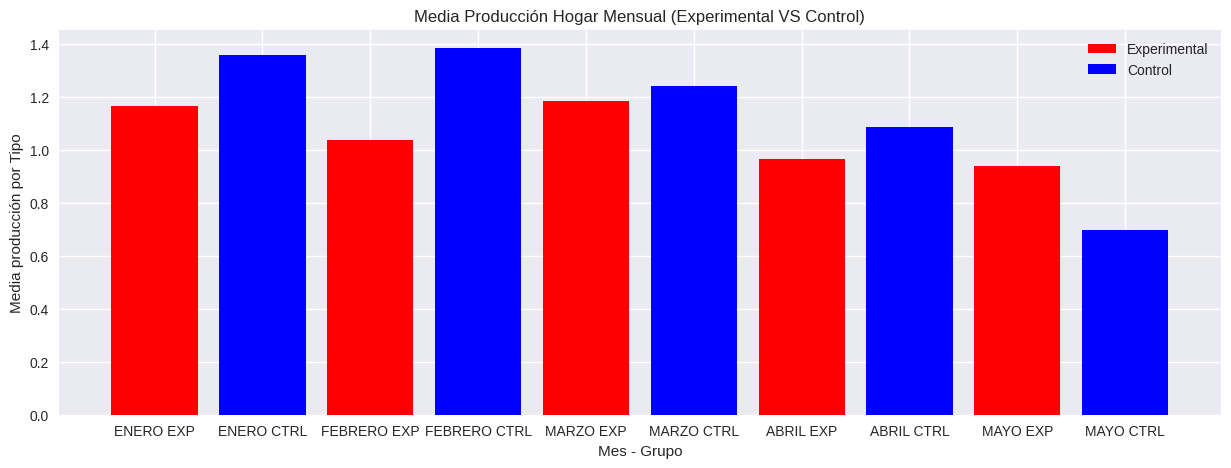

In [194]:
# Preparar datos para el gráfico
medias_hogar = [media_hogar_enero_exp, media_hogar_enero_ctrl, media_hogar_febrero_exp, media_hogar_febrero_ctrl, media_hogar_marzo_exp, media_hogar_marzo_ctrl, media_hogar_abril_exp, media_hogar_abril_ctrl, media_hogar_mayo_exp, media_hogar_mayo_ctrl]
#, media_hogar_junio_exp, media_hogar_junio_ctrl]
columnas_meses = ['ENERO EXP', 'ENERO CTRL', 'FEBRERO EXP', 'FEBRERO CTRL', 'MARZO EXP', 'MARZO CTRL', 'ABRIL EXP', 'ABRIL CTRL', 'MAYO EXP', 'MAYO CTRL']
#, 'JUNIO EXP', 'JUNIO CTRL']

# Crear el gráfico de barras
plt.figure(figsize=(15, 5))
bars = plt.bar(columnas_meses, medias_hogar, color = ['red', 'blue'])
plt.xlabel('Mes - Grupo')
plt.ylabel('Media producción por Tipo')
plt.title('Media Producción Hogar Mensual (Experimental VS Control)')
plt.legend([bars[0], bars[1]], ['Experimental', 'Control'])
plt.show()

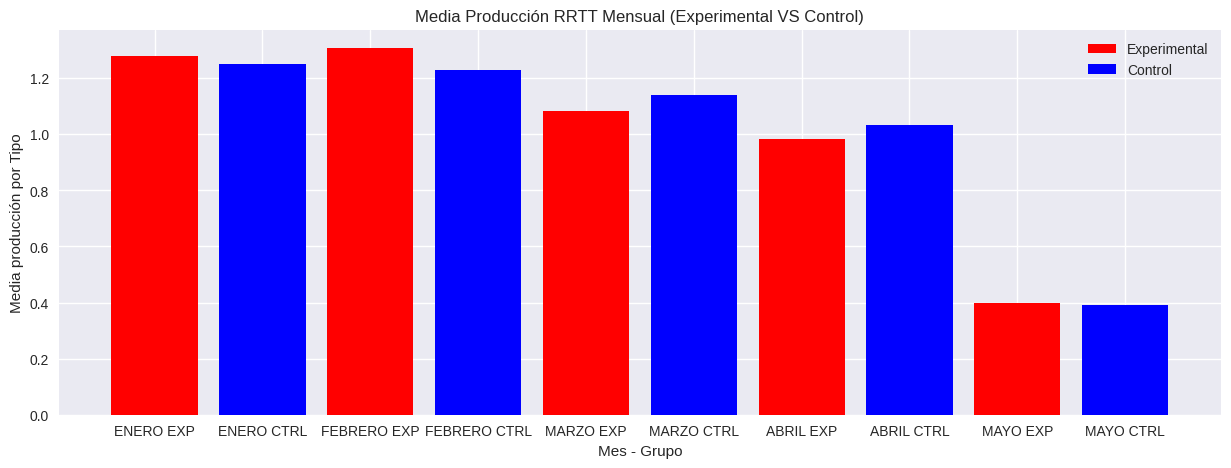

In [195]:
# Preparar datos para el gráfico
medias_rrtt = [media_rrtt_enero_exp, media_rrtt_enero_ctrl, media_rrtt_febrero_exp, media_rrtt_febrero_ctrl, media_rrtt_marzo_exp, media_rrtt_marzo_ctrl, media_rrtt_abril_exp, media_rrtt_abril_ctrl, media_rrtt_mayo_exp, media_rrtt_mayo_ctrl]
# , media_rrtt_junio_exp, media_rrtt_junio_ctrl]


# Crear el gráfico de barras
plt.figure(figsize=(15, 5))
bars = plt.bar(columnas_meses, medias_rrtt, color=['red', 'blue'])
plt.xlabel('Mes - Grupo')
plt.ylabel('Media producción por Tipo')
plt.title('Media Producción RRTT Mensual (Experimental VS Control)')
plt.legend([bars[0], bars[1]], ['Experimental', 'Control'])
plt.show()

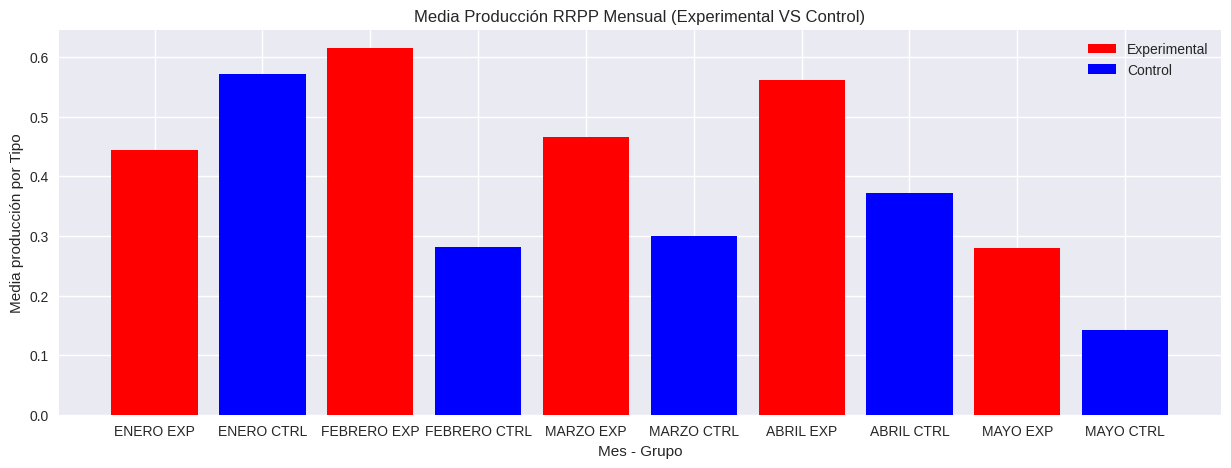

In [196]:
# Preparar datos para el gráfico
medias_rrpp = [media_rrpp_enero_exp, media_rrpp_enero_ctrl, media_rrpp_febrero_exp, media_rrpp_febrero_ctrl, media_rrpp_marzo_exp, media_rrpp_marzo_ctrl, media_rrpp_abril_exp, media_rrpp_abril_ctrl, media_rrpp_mayo_exp, media_rrpp_mayo_ctrl]
# , media_rrpp_junio_exp, media_rrpp_junio_ctrl]


# Crear el gráfico de barras
plt.figure(figsize=(15, 5))
bars = plt.bar(columnas_meses, medias_rrpp, color=['red', 'blue'])
plt.xlabel('Mes - Grupo')
plt.ylabel('Media producción por Tipo')
plt.title('Media Producción RRPP Mensual (Experimental VS Control)')
plt.legend([bars[0], bars[1]], ['Experimental', 'Control'])
plt.show()

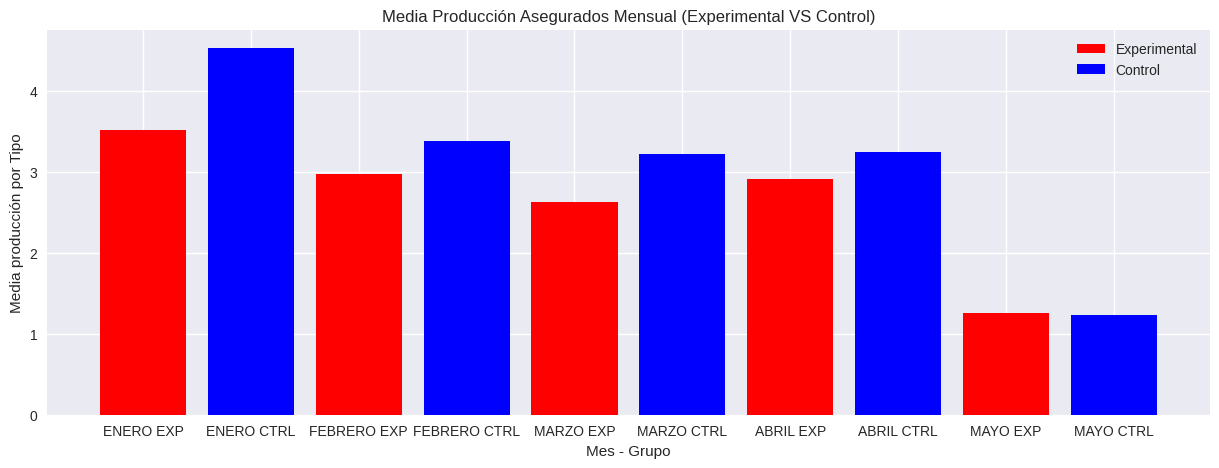

In [197]:
# Preparar datos para el gráfico
medias_aseg = [media_aseg_enero_exp, media_aseg_enero_ctrl, media_aseg_febrero_exp, media_aseg_febrero_ctrl, media_aseg_marzo_exp, media_aseg_marzo_ctrl, media_aseg_abril_exp, media_aseg_abril_ctrl, media_aseg_mayo_exp, media_aseg_mayo_ctrl]
# , media_aseg_junio_exp, media_aseg_junio_ctrl]


# Crear el gráfico de barras
plt.figure(figsize=(15, 5))
bars = plt.bar(columnas_meses, medias_aseg, color=['red', 'blue'])
plt.xlabel('Mes - Grupo')
plt.ylabel('Media producción por Tipo')
plt.title('Media Producción Asegurados Mensual (Experimental VS Control)')
plt.legend([bars[0], bars[1]], ['Experimental', 'Control'])
plt.show()

##RAPPEL TOTAL MEDIO

In [198]:
media_rappel_total_enero_exp = enero_prod_esp_exp['RAPPEL_TOTAL'].sum()/enero_prod_esp_exp.shape[0]
media_rappel_total_febrero_exp = febrero_prod_esp_exp['RAPPEL_TOTAL'].sum()/febrero_prod_esp_exp.shape[0]
media_rappel_total_marzo_exp = marzo_prod_esp_exp['RAPPEL_TOTAL'].sum()/marzo_prod_esp_exp.shape[0]
media_rappel_total_abril_exp = abril_prod_esp_exp['RAPPEL_TOTAL'].sum()/abril_prod_esp_exp.shape[0]
media_rappel_total_mayo_exp = mayo_prod_esp_exp['RAPPEL_TOTAL'].sum()/mayo_prod_esp_exp.shape[0]
# media_rappel_total_junio_exp = junio_prod_esp_exp['RAPPEL_TOTAL'].sum()/junio_prod_esp_exp.shape[0]

media_rappel_total_enero_ctrl = enero_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/enero_prod_esp_ctrl.shape[0]
media_rappel_total_febrero_ctrl = febrero_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/febrero_prod_esp_ctrl.shape[0]
media_rappel_total_marzo_ctrl = marzo_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/marzo_prod_esp_ctrl.shape[0]
media_rappel_total_abril_ctrl = abril_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/abril_prod_esp_ctrl.shape[0]
media_rappel_total_mayo_ctrl = mayo_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/mayo_prod_esp_ctrl.shape[0]
# media_rappel_total_junio_ctrl = junio_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/junio_prod_esp_ctrl.shape[0]

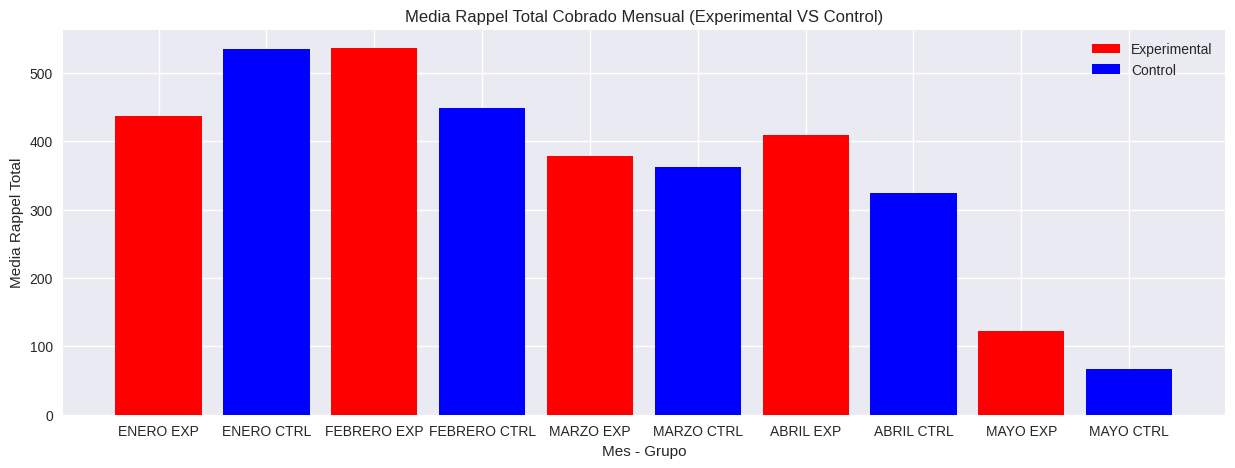

In [199]:
# Preparar datos para el gráfico
medias_rappel_total = [media_rappel_total_enero_exp, media_rappel_total_enero_ctrl, media_rappel_total_febrero_exp, media_rappel_total_febrero_ctrl, media_rappel_total_marzo_exp, media_rappel_total_marzo_ctrl, media_rappel_total_abril_exp, media_rappel_total_abril_ctrl, media_rappel_total_mayo_exp, media_rappel_total_mayo_ctrl]
# , media_rappel_total_junio_exp, media_rappel_total_junio_ctrl]


# Crear el gráfico de barras
plt.figure(figsize=(15, 5))
bars = plt.bar(columnas_meses, medias_rappel_total, color=['red', 'blue'])
plt.xlabel('Mes - Grupo')
plt.ylabel('Media Rappel Total')
plt.title('Media Rappel Total Cobrado Mensual (Experimental VS Control)')
plt.legend([bars[0], bars[1]], ['Experimental', 'Control'])
plt.show()

##RAPPEL COBRADO PORCENTUAL


####Grupo Experimental

In [200]:
porcentaje_rappel_cobrado_enero_exp = (enero_prod_esp_exp['COBRA_RAPPEL'].sum()/enero_prod_esp_exp.shape[0])*100
porcentaje_rappel_cobrado_febrero_exp = (febrero_prod_esp_exp['COBRA_RAPPEL'].sum()/febrero_prod_esp_exp.shape[0])*100
porcentaje_rappel_cobrado_marzo_exp = (marzo_prod_esp_exp['COBRA_RAPPEL'].sum()/marzo_prod_esp_exp.shape[0])*100
porcentaje_rappel_cobrado_abril_exp = (abril_prod_esp_exp['COBRA_RAPPEL'].sum()/abril_prod_esp_exp.shape[0])*100
porcentaje_rappel_cobrado_mayo_exp = (mayo_prod_esp_exp['COBRA_RAPPEL'].sum()/mayo_prod_esp_exp.shape[0])*100
# porcentaje_rappel_cobrado_junio_exp = (junio_prod_esp_exp['COBRA_RAPPEL'].sum()/junio_prod_esp_exp.shape[0])*100

porcentaje_rappel_cobrado_enero_ctrl = (enero_prod_esp_ctrl['COBRA_RAPPEL'].sum()/enero_prod_esp_ctrl.shape[0])*100
porcentaje_rappel_cobrado_febrero_ctrl = (febrero_prod_esp_ctrl['COBRA_RAPPEL'].sum()/febrero_prod_esp_ctrl.shape[0])*100
porcentaje_rappel_cobrado_marzo_ctrl = (marzo_prod_esp_ctrl['COBRA_RAPPEL'].sum()/marzo_prod_esp_ctrl.shape[0])*100
porcentaje_rappel_cobrado_abril_ctrl = (abril_prod_esp_ctrl['COBRA_RAPPEL'].sum()/abril_prod_esp_ctrl.shape[0])*100
porcentaje_rappel_cobrado_mayo_ctrl = (mayo_prod_esp_ctrl['COBRA_RAPPEL'].sum()/mayo_prod_esp_ctrl.shape[0])*100
# porcentaje_rappel_cobrado_junio_ctrl = (junio_prod_esp_ctrl['COBRA_RAPPEL'].sum()/junio_prod_esp_ctrl.shape[0])*100

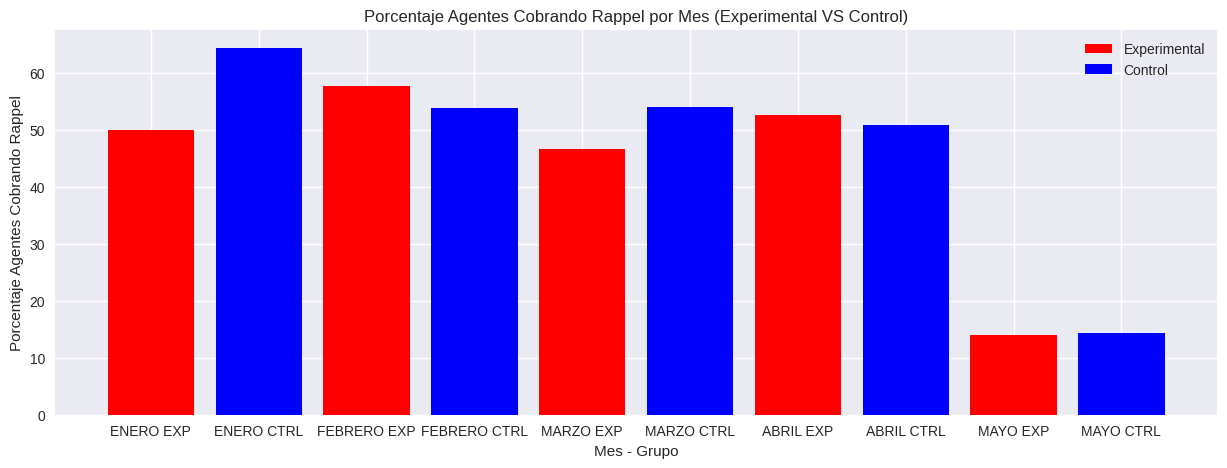

In [201]:
# Preparar datos para el gráfico
porcentaje_rappel_cobrado = [porcentaje_rappel_cobrado_enero_exp, porcentaje_rappel_cobrado_enero_ctrl, porcentaje_rappel_cobrado_febrero_exp, porcentaje_rappel_cobrado_febrero_ctrl, porcentaje_rappel_cobrado_marzo_exp, porcentaje_rappel_cobrado_marzo_ctrl, porcentaje_rappel_cobrado_abril_exp, porcentaje_rappel_cobrado_abril_ctrl, porcentaje_rappel_cobrado_mayo_exp, porcentaje_rappel_cobrado_mayo_ctrl]
# , porcentaje_rappel_cobrado_junio_exp, porcentaje_rappel_cobrado_junio_ctrl]


# Crear el gráfico de barras
plt.figure(figsize=(15, 5))
bars = plt.bar(columnas_meses, porcentaje_rappel_cobrado, color=['red', 'blue'])
plt.xlabel('Mes - Grupo')
plt.ylabel('Porcentaje Agentes Cobrando Rappel')
plt.title('Porcentaje Agentes Cobrando Rappel por Mes (Experimental VS Control)')
plt.legend([bars[0], bars[1]], ['Experimental', 'Control'])
plt.show()

####Solo agentes estándar para el XXL

In [202]:
enero_prod_esp_exp_est = enero_prod_esp_exp[enero_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]
febrero_prod_esp_exp_est = febrero_prod_esp_exp[febrero_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]
marzo_prod_esp_exp_est = marzo_prod_esp_exp[marzo_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]
abril_prod_esp_exp_est = abril_prod_esp_exp[abril_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]
mayo_prod_esp_exp_est = mayo_prod_esp_exp[mayo_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]
# junio_prod_esp_exp_est = junio_prod_esp_exp[junio_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]

enero_prod_esp_ctrl_est = enero_prod_esp_ctrl[enero_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]
febrero_prod_esp_ctrl_est = febrero_prod_esp_ctrl[febrero_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]
marzo_prod_esp_ctrl_est = marzo_prod_esp_ctrl[marzo_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]
abril_prod_esp_ctrl_est = abril_prod_esp_ctrl[abril_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]
mayo_prod_esp_ctrl_est = mayo_prod_esp_ctrl[mayo_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]
# junio_prod_esp_ctrl_est = junio_prod_esp_ctrl[junio_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]

In [203]:
porcentaje_rappelxxl_cobrado_enero_exp = (enero_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/enero_prod_esp_exp_est.shape[0])*100
porcentaje_rappelxxl_cobrado_febrero_exp = (febrero_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/febrero_prod_esp_exp_est.shape[0])*100
porcentaje_rappelxxl_cobrado_marzo_exp = (marzo_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/marzo_prod_esp_exp_est.shape[0])*100
porcentaje_rappelxxl_cobrado_abril_exp = (abril_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/abril_prod_esp_exp_est.shape[0])*100
porcentaje_rappelxxl_cobrado_mayo_exp = (mayo_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/mayo_prod_esp_exp_est.shape[0])*100
# porcentaje_rappelxxl_cobrado_junio_exp = (junio_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/junio_prod_esp_exp_est.shape[0])*100

porcentaje_rappelxxl_cobrado_enero_ctrl = (enero_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/enero_prod_esp_ctrl.shape[0])*100
porcentaje_rappelxxl_cobrado_febrero_ctrl = (febrero_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/febrero_prod_esp_ctrl.shape[0])*100
porcentaje_rappelxxl_cobrado_marzo_ctrl = (marzo_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/marzo_prod_esp_ctrl.shape[0])*100
porcentaje_rappelxxl_cobrado_abril_ctrl = (abril_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/abril_prod_esp_ctrl.shape[0])*100
porcentaje_rappelxxl_cobrado_mayo_ctrl = (mayo_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/mayo_prod_esp_ctrl.shape[0])*100
# porcentaje_rappelxxl_cobrado_junio_ctrl = (junio_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/junio_prod_esp_ctrl.shape[0])*100

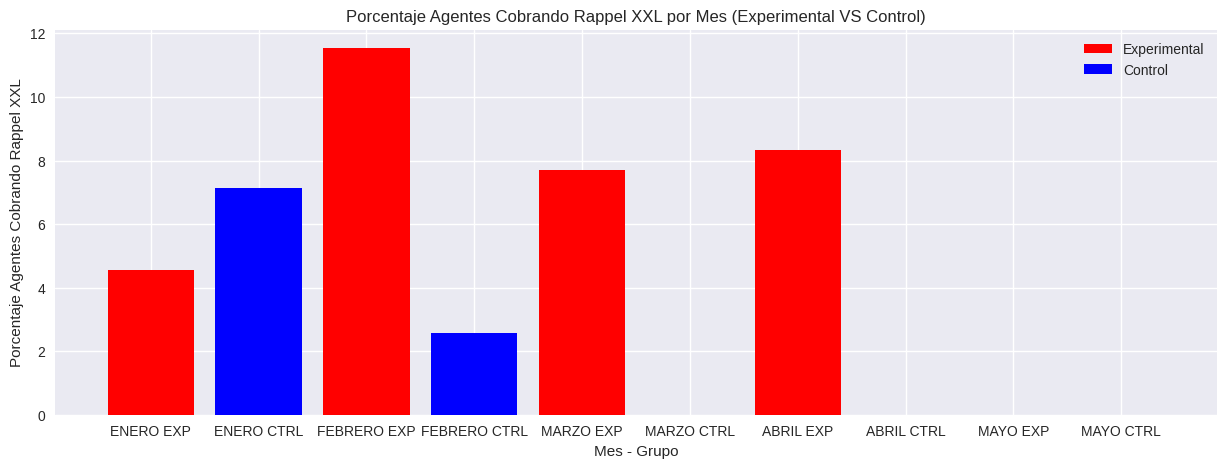

In [204]:
# Preparar datos para el gráfico
porcentaje_rappelxxl_cobrado = [porcentaje_rappelxxl_cobrado_enero_exp, porcentaje_rappelxxl_cobrado_enero_ctrl, porcentaje_rappelxxl_cobrado_febrero_exp, porcentaje_rappelxxl_cobrado_febrero_ctrl, porcentaje_rappelxxl_cobrado_marzo_exp, porcentaje_rappelxxl_cobrado_marzo_ctrl, porcentaje_rappelxxl_cobrado_abril_exp, porcentaje_rappelxxl_cobrado_abril_ctrl, porcentaje_rappelxxl_cobrado_mayo_exp, porcentaje_rappelxxl_cobrado_mayo_ctrl]
# , porcentaje_rappelxxl_cobrado_junio_exp, porcentaje_rappelxxl_cobrado_junio_ctrl]


# Crear el gráfico de barras
plt.figure(figsize=(15, 5))
bars = plt.bar(columnas_meses, porcentaje_rappelxxl_cobrado, color=['red', 'blue'])
plt.xlabel('Mes - Grupo')
plt.ylabel('Porcentaje Agentes Cobrando Rappel XXL')
plt.title('Porcentaje Agentes Cobrando Rappel XXL por Mes (Experimental VS Control)')
plt.legend([bars[0], bars[1]], ['Experimental', 'Control'])
plt.show()

**OTROS ESTUDIOS QUE SE PUEDEN HACER:**



*   Filtrar solo por tipo de evento READ para ver en una gráfica el impacto por sucursales (u oficinas o puntos de venta).
*   Usar como grupo de control_2 el grupo experimental en los 3 meses anteriores para ver cómo varía.